# Detección de neumonía
#### Proyecto: AIRE
#### - Luis Carlos Romero Cardenas.
#### - Maria Camila Plazas Gómez.
#### - Alejandra Gómez.
#### - Efraín Santiago Mayorga Chaves. 

## 1. Importar datos

In [1]:
!pip install kagglehub

Solo ejecutar si se requiere descargar las imágenes desde Kaggle

In [4]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")

# print("Path to dataset files:", path)

100%|██████████| 2.29G/2.29G [08:33<00:00, 4.80MB/s]

Extracting files...


Path to dataset files: C:\Users\Luis Romero\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


### 1.1. Importar librerias

In [2]:
#!pip uninstall numpy -y
#!pip uninstall pandas numpy -y
!pip install numpy==1.26.4 pandas==2.2.2 tensorflow==2.16.1 scikit-learn matplotlib mlflow


  Using cached docker-7.1.0-py3-none-any.whl.metadata (3.8 kB)
  Using cached graphene-3.4.3-py2.py3-none-any.whl.metadata (6.9 kB)
  Using cached waitress-3.0.2-py3-none-any.whl.metadata (5.8 kB)
  Using cached click-8.2.1-py3-none-any.whl.metadata (2.5 kB)
  Using cached blinker-1.9.0-py3-none-any.whl.metadata (1.6 kB)
  Using cached itsdangerous-2.2.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached graphql_relay-3.2.0-py3-none-any.whl.metadata (12 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached pyasn1-0.6.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ---------------------------------------  11.5/11.6 MB 65.9 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 45.4 MB/s eta 0:00:00
   ---------------------------------------- 

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.6.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.
jaxlib 0.6.2 requires ml_dtypes>=0.5.0, but you have ml-dtypes 0.3.2 which is incompatible.


### 📦 Instalación de librerías

Se instalan versiones específicas para asegurar **compatibilidad** y **reproducibilidad** del proyecto:

- **`numpy==1.26.4`**: Versión moderna y estable, compatible con TensorFlow y otras librerías.
- **`pandas==2.2.2`**: Eficiente para manipular datos tabulares como etiquetas o rutas de imágenes.
- Las versiones están fijadas para evitar **errores de compatibilidad** y asegurar que el código funcione igual en cualquier entorno.




In [1]:
#librerias estándar
import os
from collections import Counter

#librerias de manejo de datos
import pandas as pd
import numpy as np

#librerias de deep learning
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import DenseNet121


#librerias de visualización
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight


In [2]:

# Ruta completa al conjunto de datos
path=''
data_dir = os.path.join(path, 'Data', 'chest_xray')
data_dir

# Cargar las imágenes desde las carpetas train, test y val
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

# Crear datasets para train, test y val
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32,
    #shuffle=True 
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(256, 256),
    batch_size=32,
    shuffle=False 
)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    image_size=(256, 256),
    batch_size=32
)

print("Datasets cargados exitosamente.")

Found 5216 files belonging to 2 classes.
Found 624 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Datasets cargados exitosamente.


###  Carga del dataset de radiografías

Se define la ruta del conjunto de datos `chest_xray`, que contiene tres subdirectorios: **train**, **test** y **val**. Cada uno incluye imágenes de radiografías clasificadas en dos clases: `NORMAL` y `PNEUMONIA`.

Luego, se crean datasets de TensorFlow a partir de estas carpetas usando `image_dataset_from_directory`, que permite cargar y etiquetar automáticamente las imágenes según su carpeta.

- **Tamaño de imagen**: 256x256 píxeles
- **Tamaño de lote**: 32 imágenes por batch
- **`shuffle=False`** en el conjunto de prueba para mantener el orden

>  Esta estructura es común en tareas de clasificación de imágenes, ya que facilita el entrenamiento y la evaluación de modelos con Keras.


### 1.2 Determinar el tamaño original de las imágenes.

In [3]:
image_paths = []
for root, dirs, files in os.walk(train_dir):
    for file in files:
        if file.lower().endswith(('jpg', 'jpeg', 'png')):
            image_paths.append(os.path.join(root, file))

# Mostrar dimensiones originales de las primeras 5 imágenes
for path in image_paths[:5]:
    img_raw = tf.io.read_file(path)
    img = tf.image.decode_image(img_raw)
    print(f"{os.path.basename(path)}: {img.shape}")

IM-0115-0001.jpeg: (1858, 2090, 1)
IM-0117-0001.jpeg: (1152, 1422, 1)
IM-0119-0001.jpeg: (1434, 1810, 1)
IM-0122-0001.jpeg: (1279, 1618, 1)
IM-0125-0001.jpeg: (1125, 1600, 1)



### Exploración inicial de las imágenes

Debido al tamaño de promedio de cada imagen y que podría impactar el rendimiento en el entrenamiento del modelo se hará un reescalado de cada imagen a un tamaño estandar de 256 x 256 pixels. Adicional, se evidencia que son imágenes en escala de grises


Se recorren las carpetas del conjunto de entrenamiento (`train_dir`) para:

- Obtener las rutas de todas las imágenes con extensiones comunes (`.jpg`, `.jpeg`, `.png`)
- Mostrar las **dimensiones originales** (alto, ancho, canales) de las primeras 5 imágenes

Esto permite entender mejor la **variabilidad en tamaños** de las imágenes antes de aplicar transformaciones o preprocesamiento.

> 🖼️ Verificar las dimensiones originales es útil para decidir si es necesario redimensionar o normalizar las imágenes de forma consistente.



Cada línea muestra el **nombre del archivo** y su forma `(alto, ancho, canales)`:

- Los valores indican que las imágenes tienen **resoluciones variables**, lo cual es común en datasets médicos.
- El tercer valor (`1`) representa que las imágenes son en **escala de grises** (un solo canal).

> 🖼️ Esta inspección es clave para decidir si se deben redimensionar y convertir las imágenes a un formato estándar antes de usarlas en un modelo.


### 1.3. Muestra de los datos

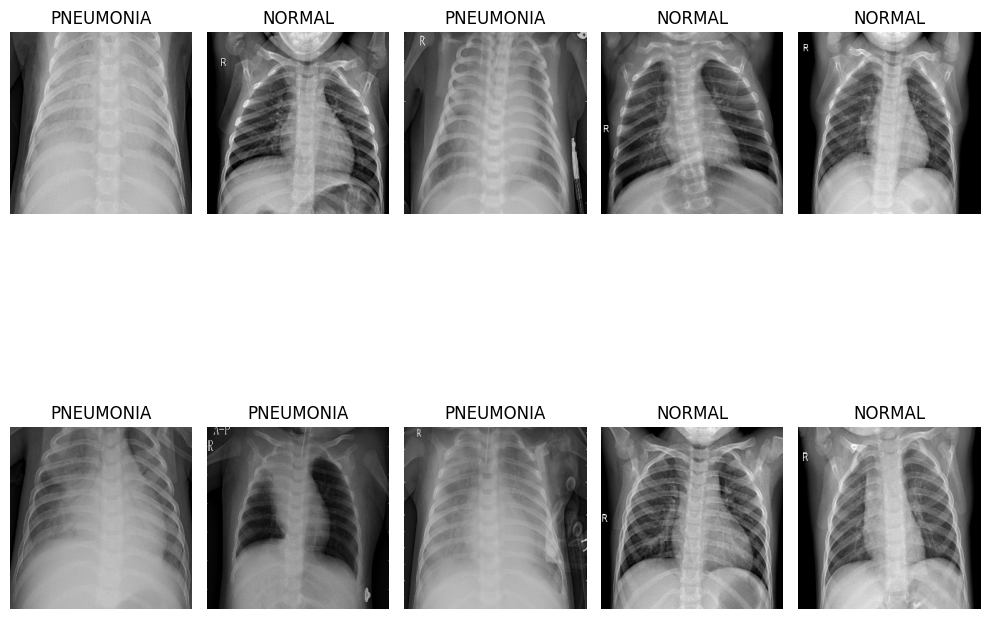

In [4]:

# Obtener las clases del conjunto de entrenamiento
class_names = train_dataset.class_names

# Inicializar contadores para las categorías
category_counts = {class_name: 0 for class_name in class_names}
max_images_per_category = 5

# Crear una lista para almacenar las imágenes y etiquetas
images_to_plot = []
labels_to_plot = []

# Iterar sobre el conjunto de entrenamiento
for images, labels in train_dataset:
    for image, label in zip(images, labels):
        class_name = class_names[label.numpy()]
        if category_counts[class_name] < max_images_per_category:
            images_to_plot.append(image)
            labels_to_plot.append(class_name)
            category_counts[class_name] += 1
        # Romper el bucle si ya tenemos suficientes imágenes
        if all(count >= max_images_per_category for count in category_counts.values()):
            break
    if all(count >= max_images_per_category for count in category_counts.values()):
        break

# Graficar las imágenes
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(zip(images_to_plot, labels_to_plot)):
    plt.subplot(2, max_images_per_category, i + 1)
    plt.imshow(image.numpy().astype("uint8"))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

###  Visualización de imágenes por categoría

Esta celda permite **visualizar ejemplos representativos** de cada clase del conjunto de entrenamiento.

####  ¿Qué hace el código?

- Obtiene las **clases** detectadas en `train_dataset` (`NORMAL` y `PNEUMONIA`).
- Selecciona hasta **5 imágenes por clase** para graficarlas.
- Recorre el dataset por lotes y guarda imágenes junto a sus etiquetas hasta alcanzar el límite por clase.
- Finalmente, muestra las imágenes en un **grid organizado**, con su clase como título.

####  ¿Por qué es útil?

- Permite una **inspección visual rápida** de los datos, ideal para confirmar que las imágenes están bien cargadas y etiquetadas.
- Ayuda a entender diferencias visuales entre clases y a detectar posibles errores en el dataset.

>  Esta práctica es clave en visión por computadora para familiarizarse con la distribución visual del conjunto de datos antes del entrenamiento.


# 2. Preprocesar Datos

### 2.1. Determinar las características del conjunto de datos:


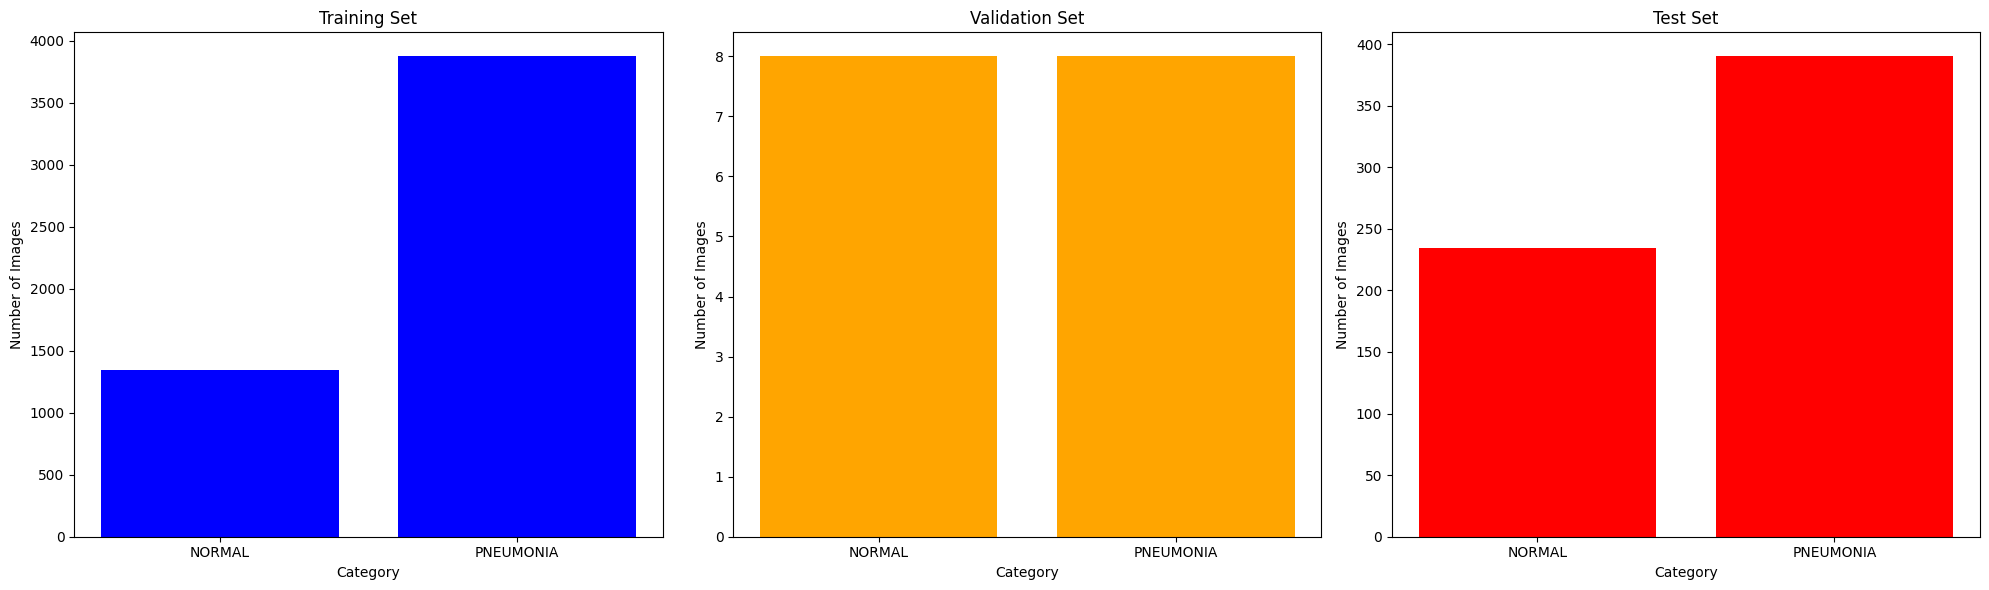

Número de imágenes por categoría en el conjunto de entrenamiento: [1341 3875]
Número de imágenes por categoría en el conjunto de validación: [8 8]
Número de imágenes por categoría en el conjunto de prueba: [234 390]


In [5]:
categories = train_dataset.class_names

# Función para contar las ocurrencias por clase
def count_labels(dataset, num_classes):
    all_labels = []
    for images, labels in dataset:
        all_labels.extend(labels.numpy())
    counts = np.bincount(all_labels, minlength=num_classes)
    return counts

# Obtener los conteos
num_classes = len(categories)
train_counts = count_labels(train_dataset, num_classes)
val_counts = count_labels(val_dataset, num_classes)
test_counts = count_labels(test_dataset, num_classes)

# Crear una figura y ejes
fig, ax = plt.subplots(1, 3, figsize=(20, 6))

# Gráficos
ax[0].bar(categories, train_counts, color='blue')
ax[0].set_title('Training Set')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Number of Images')

ax[1].bar(categories, val_counts, color='orange')
ax[1].set_title('Validation Set')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Number of Images')

ax[2].bar(categories, test_counts, color='red')
ax[2].set_title('Test Set')
ax[2].set_xlabel('Category')
ax[2].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()

print("Número de imágenes por categoría en el conjunto de entrenamiento:", train_counts)
print("Número de imágenes por categoría en el conjunto de validación:", val_counts)
print("Número de imágenes por categoría en el conjunto de prueba:", test_counts)

###  Distribución de clases en los datasets

Esta celda analiza cuántas imágenes hay por categoría (**`NORMAL`** y **`PNEUMONIA`**) en cada subconjunto: **entrenamiento**, **validación** y **prueba**.

####  ¿Qué hace el código?

- Define una función `count_labels()` que recorre los datasets y cuenta cuántas veces aparece cada clase.
- Aplica esta función a los tres conjuntos: `train_dataset`, `val_dataset` y `test_dataset`.
- Visualiza los resultados mediante tres gráficos de barras, uno por conjunto.

####  Ejemplo de salida (resumen impreso):
Se logra evidenciar un desbalanceo del tamaño por cada categoría, en los conjuntos de entrenamiento y prueba. Lo que reuiqre aplicar técnicas para el manejar el desbalanceo y que no afecte el entrenamiento.

<hr style="height:3px; background-color:white; border:none;" />



####  Observaciones:

- El conjunto de **entrenamiento** está **desbalanceado**, con muchas más imágenes de `PNEUMONIA` que de `NORMAL`.
- El conjunto de **validación** tiene muy pocas imágenes (solo **8 por clase**), lo cual puede ser insuficiente para una evaluación robusta.
- El conjunto de **prueba** tiene una distribución similar al de entrenamiento, aunque más equilibrada.

> ⚠️ Este tipo de desbalance puede afectar el aprendizaje del modelo y requiere estrategias como **ponderar las clases**, **aumentar los datos** o **usar métricas adecuadas** (como F1-score o AUC).


### 2.2. Aplicar la técnica de aumento de datos para el conjunto de datos de entrenamiento únicamente:

In [125]:
# Aumento de datos definido como un modelo secuencial
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.08),
    layers.RandomZoom(0.08),
    layers.RandomTranslation(0.08, 0.08),
    layers.RandomContrast(0.08),
])

# Cargar dataset desde carpeta
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(256, 256),
    batch_size=32
)

# Aplicar el aumento de datos solo al entrenamiento
# (no lo aplicamos a validación ni prueba)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))

Found 5216 files belonging to 2 classes.


###  Aumento de datos (Data Augmentation)

Para mejorar la **generalización del modelo** y reducir el sobreajuste, se aplica **aumento de datos** (data augmentation) al conjunto de entrenamiento.

####  ¿Qué hace el código?

- Se define una secuencia de transformaciones aleatorias usando `tf.keras.Sequential`, incluyendo:
  - **Flip horizontal** (`RandomFlip`): invierte la imagen lateralmente.
  - **Rotación** (`RandomRotation`): rota ligeramente la imagen.
  - **Zoom** (`RandomZoom`): acerca o aleja ligeramente.
  - **Traslación** (`RandomTranslation`): mueve la imagen horizontal y verticalmente.
  - **Contraste** (`RandomContrast`): varía la intensidad de contraste.

- Luego, se vuelve a cargar el dataset de entrenamiento y se aplica la transformación con `map()`, manteniendo las etiquetas originales.

>  Estas transformaciones se aplican **solo durante el entrenamiento**, para simular mayor variedad de imágenes y ayudar al modelo a aprender características más robustas.

>  No se aplican al conjunto de validación ni prueba, ya que esas fases requieren datos sin alterar para evaluar el rendimiento real del modelo.


<hr style="height:3px; background-color:white; border:none;" />

## Salida


Esto confirma que el conjunto de entrenamiento contiene **5216 imágenes** distribuidas entre las dos clases (`NORMAL` y `PNEUMONIA`).

>  Las transformaciones se aplican **solo durante el entrenamiento**, permitiendo al modelo ver versiones ligeramente distintas de las imágenes en cada época, lo que ayuda a aprender de forma más robusta.


# 3. Modelo 
### 3.1. Definir parámetros del modelo:

In [6]:
size_filter=(3, 3)
input_shape = (256, 256, 3)
size_classes = len(class_names)
epochs = 30
batch_size = 32
val_image_count = sum([len(files) for r, d, files in os.walk(val_dir) if files])
validation_steps=val_image_count//batch_size
train_image_count = sum([len(files) for r, d, files in os.walk(train_dir) if files])
train_steps=train_image_count//batch_size
test_image_count = sum([len(files) for r, d, files in os.walk(test_dir) if files])
test_steps=test_image_count//batch_size
labels_names = ['NORMAL', 'PNEUMONIA']

###  Definición de parámetros y configuración inicial

Se definen parámetros clave para la configuración del modelo y la preparación del entrenamiento:

- **`size_filter = (3, 3)`**: Tamaño del filtro que se usará en las capas convolucionales.
- **`input_shape = (256, 256, 3)`**: Tamaño de entrada de las imágenes (ancho, alto, canales RGB). Aunque las imágenes originales son en escala de grises, se procesan como si tuvieran 3 canales para ser compatibles con modelos estándar de Keras.
- **`size_classes = len(class_names)`**: Número de clases detectadas (`NORMAL`, `PNEUMONIA`).

####  Hiperparámetros del entrenamiento:

- **`epochs = 30`**: Número de épocas de entrenamiento.
- **`batch_size = 32`**: Tamaño del lote.

####  Cálculo de pasos por época (steps per epoch):

Se calcula cuántas veces hay que iterar por conjunto para cubrir todos los datos:

- **`train_steps`** = total de imágenes de entrenamiento dividido por `batch_size`
- **`validation_steps`** = total de imágenes de validación dividido por `batch_size`
- **`test_steps`** = total de imágenes de prueba dividido por `batch_size`

Esto es útil para los métodos `.fit()` y `.evaluate()` del modelo.

####  Etiquetas:

- **`labels_names = ['NORMAL', 'PNEUMONIA']`**: Lista explícita de nombres de clases, útil para interpretar predicciones o visualizar resultados.

> ✅ Esta configuración prepara el entorno para entrenar de forma controlada y reproducible.


### 3.2 Definir el modelo de CNN

In [41]:
model = models.Sequential([
    layers.Conv2D(32,size_filter , activation='relu', input_shape=input_shape,
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, size_filter, activation='relu',
                  kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),  # Añadir Dropout con una tasa del 50%
    layers.Dense(size_classes, activation='softmax')
])


###  Definición del modelo CNN (Red Neuronal Convolucional)

Se construye un modelo secuencial (`Sequential`) utilizando **capas convolucionales** para el reconocimiento de imágenes de rayos X con y sin neumonía.

####  Arquitectura del modelo:

1. **`Conv2D(32, (3, 3), activation='relu')`**  
   - 32 filtros con tamaño 3×3  
   - Activación ReLU  
   - Regularización L2 (`l2(0.001)`) para evitar sobreajuste  
   - Primera capa: define la forma de entrada `input_shape=(256, 256, 3)`

2. **`MaxPooling2D((2, 2))`**  
   - Reduce la resolución espacial a la mitad  
   - Conserva características importantes

3. **`Conv2D(64, (3, 3), activation='relu')` + `MaxPooling2D`**  
   - Segunda capa convolucional con más filtros (64) para capturar patrones más complejos

4. **`Conv2D(128, (3, 3), activation='relu')` + `MaxPooling2D`**  
   - Tercera capa convolucional con 128 filtros  
   - Extrae características de alto nivel

5. **`Flatten()`**  
   - Convierte la salida 2D en un vector 1D para conectarse a capas densas

6. **`Dense(128, activation='relu')`**  
   - Capa totalmente conectada  
   - También incluye regularización L2

7. **`Dropout(0.5)`**  
   - Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento  
   - Reduce el riesgo de sobreajuste

8. **`Dense(size_classes, activation='softmax')`**  
   - Capa de salida con tantas neuronas como clases (`2`)  
   - Softmax convierte la salida en probabilidades

> ✅ Esta arquitectura es adecuada para tareas de clasificación de imágenes y está diseñada para **prevenir el sobreajuste** mediante regularización y dropout.


### 3.3. Compilar el modelo

In [44]:

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=[
                  'accuracy',
                  metrics.Precision(name='precision'),
                  metrics.Recall(name='recall')
                  ])
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 60, 60, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,839,234 (56.61 MB)

 Trainable params: 14,839,234 (56.61 MB)

 Non-trainable params: 0 (0.00 B)

###  Compilación del modelo

Una vez definida la arquitectura, se **compila** el modelo indicando el optimizador, la función de pérdida y las métricas a evaluar durante el entrenamiento.

####  Parámetros de compilación:

- **`optimizer='adam'`**  
  Utiliza el optimizador **Adam**, muy popular por su eficiencia y buen rendimiento en la mayoría de los problemas de deep learning.

- **`loss='sparse_categorical_crossentropy'`**  
  Función de pérdida usada para clasificación **multiclase** con etiquetas enteras.  
  *(Ideal cuando las clases están codificadas como 0 y 1 en lugar de one-hot)*

- **`metrics=[...]`**  
  Se monitorean varias métricas:
  - **`accuracy`**: exactitud general
  - **`precision`**: proporción de verdaderos positivos entre todas las predicciones positivas
  - **`recall`**: proporción de verdaderos positivos entre todos los casos reales positivos

####  `model.summary()`

Muestra un resumen estructurado del modelo, incluyendo:
- El nombre y tipo de cada capa
- El número de parámetros entrenables
- El tamaño de salida de cada capa

> ✅ Esta configuración es adecuada para tareas de clasificación de imágenes con dos clases, y permite evaluar el modelo no solo por precisión general, sino también por cómo se comporta en términos de errores tipo I y II.


<hr style="height:3px; background-color:white; border:none;" />

## Salida

###  Resumen del modelo (`model.summary()`)

A continuación, se detalla la arquitectura del modelo entrenado para clasificar radiografías de tórax en dos clases: **NORMAL** y **PNEUMONIA**.

####  Estructura del modelo convolucional:

| Capa | Tipo | Dimensiones de salida | Parámetros | Descripción |
|------|------|------------------------|------------|-------------|
| `Conv2D` | Convolucional (32 filtros, 3x3) | (254, 254, 32) | 896 | Extrae características locales como bordes y texturas |
| `MaxPooling2D` | Submuestreo | (127, 127, 32) | 0 | Reduce la resolución y el cómputo |
| `Conv2D` | Convolucional (64 filtros) | (125, 125, 64) | 18,496 | Aprende patrones más complejos |
| `MaxPooling2D` | Submuestreo | (62, 62, 64) | 0 | Reducción adicional de resolución |
| `Conv2D` | Convolucional (128 filtros) | (60, 60, 128) | 73,856 | Extrae características de alto nivel |
| `MaxPooling2D` | Submuestreo | (30, 30, 128) | 0 | Preparación para capa densa |
| `Flatten` | Reestructuración | (115200,) | 0 | Convierte mapas de activación en vector |
| `Dense` | Capa totalmente conectada (128) | (128,) | 14,745,728 | Aprende combinaciones complejas de características |
| `Dropout(0.5)` | Regularización | (128,) | 0 | Previene el sobreajuste apagando el 50% de neuronas |
| `Dense` | Capa de salida (2 clases) | (2,) | 258 | Predice clase final con activación softmax |

####  Parámetros totales:
- **Total de parámetros**: `14,839,234` (~56.6 MB)
- **Entrenables**: `100%` del total
- **No entrenables**: `0`

> ✅ La mayoría de los parámetros están en la **capa densa** intermedia (`Dense(128)`), ya que recibe una entrada muy grande tras el `Flatten`.

Este modelo está optimizado para clasificar imágenes médicas en dos clases con **alta capacidad de aprendizaje**, pero también incluye mecanismos para reducir el sobreajuste como la **regularización L2** y el **Dropout**.


### 3.4.  Entrenar el modelo

In [45]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_steps,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=epochs
)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.6957 - loss: 28.9797 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.4375 - val_loss: 1.4235
Epoch 3/30


c:\ProgramData\anaconda3\envs\mlops\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 179s 1s/step - accuracy: 0.7857 - loss: 0.8373 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.6420
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 186s 1s/step - accuracy: 0.7774 - loss: 0.8026 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.6250 - val_loss: 1.2000
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 181s 1s/step - accuracy: 0.7782 - loss: 1.0276 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7500 - val_loss: 0.9236
Epoch 9/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 171s 1s/step - accuracy: 0.8026 - loss: 0.7367 - val_accuracy: 0.5625 - val_loss: 1.0156
Epoch 10/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0

### 3.4. Evaluar el modelo en el conjunto de prueba

In [56]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 223ms/step - accuracy: 0.4135 - loss: 1.3995
Test accuracy: 0.6682692170143127


###  Evaluación del modelo en el conjunto de prueba

Una vez entrenado, se evalúa el rendimiento del modelo usando el conjunto de **prueba**, que contiene imágenes **nunca vistas** durante el entrenamiento ni la validación.


###  Interpretación de los resultados de prueba

Tras evaluar el modelo sobre el conjunto de **prueba**, se obtuvieron los siguientes resultados:

- **Pérdida (`loss`)**: `1.3995`
- **Precisión (`accuracy`)**: `66.83%`

####  ¿Qué significa esto?

- La precisión indica que el modelo clasificó correctamente cerca del **67%** de las radiografías no vistas.  
- Sin embargo, el valor de **pérdida elevado** sugiere que el modelo tiene **incertidumbre o errores significativos** en sus predicciones.
- Puede deberse a:
  - Un **modelo sobreajustado** (overfitting) al conjunto de entrenamiento.
  - Un posible **desequilibrio de clases** (por ejemplo, más casos de neumonía que normales).
  - La arquitectura actual podría no ser lo suficientemente profunda o generalizable.

>  En aplicaciones médicas, una precisión del **67% puede no ser aceptable**, especialmente si se desea minimizar falsos negativos (no detectar neumonía cuando sí está presente).



### 3.5 Métricas

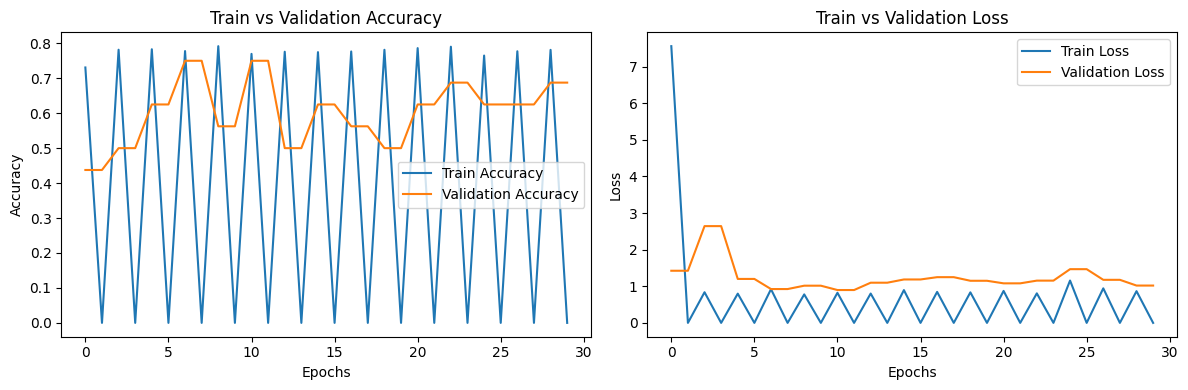

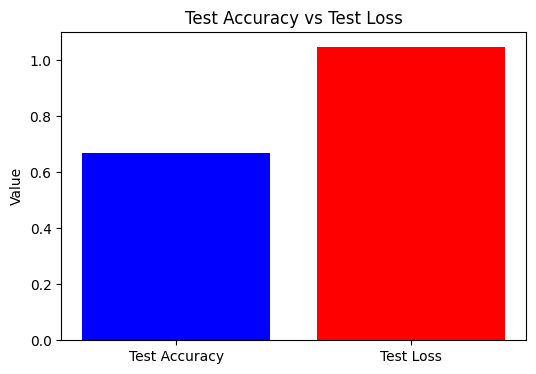

In [57]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


###  Análisis de Rendimiento del Modelo

####  Entrenamiento vs Validación

**1. Precisión (`Accuracy`)**
- La curva de **entrenamiento** muestra una oscilación muy pronunciada, indicando una posible inestabilidad en el aprendizaje.
- La **precisión de validación** se mantiene mucho más estable y alcanza un valor máximo de ~0.75, aunque sin una tendencia clara de mejora.
- Esto sugiere que el modelo no está aprendiendo de forma constante y probablemente esté **sobreajustándose** a los datos de entrenamiento.

**2. Pérdida (`Loss`)**
- La pérdida de entrenamiento desciende con oscilaciones, pero se mantiene baja.
- La pérdida de validación es mucho más estable y no mejora significativamente después de las primeras épocas.
- Esta divergencia entre la pérdida de entrenamiento y validación es un indicio claro de **overfitting**.

---

####  Desempeño en Pruebas

**Gráfico de Precisión vs Pérdida (Test)**
- El modelo alcanza una **precisión en el conjunto de prueba** de aproximadamente **0.67**, lo cual es moderado.
- La **pérdida de prueba** (~1.4) es relativamente alta, lo que refuerza la idea de que el modelo tiene dificultad para generalizar.

---

###  Conclusión

- El modelo está **memorando** los datos de entrenamiento pero no está generalizando bien a nuevos datos.
- Se recomienda:
  - Usar técnicas de **regularización más agresivas** o **early stopping**.
  - Explorar arquitecturas más robustas o aplicar **transfer learning**.
  - Aumentar y balancear el conjunto de datos, si es posible.


### 3.6 Reporte de clasificación

Longitudes: 624 624


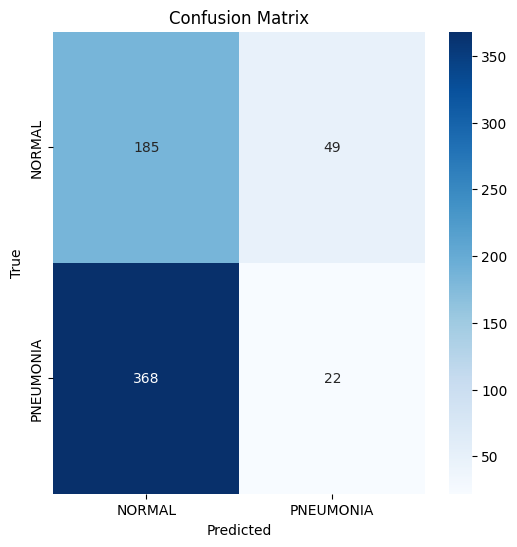

              precision    recall  f1-score   support

      NORMAL       0.33      0.79      0.47       234
   PNEUMONIA       0.31      0.06      0.10       390

    accuracy                           0.33       624
   macro avg       0.32      0.42      0.28       624
weighted avg       0.32      0.33      0.24       624



In [64]:
y_true = []
y_pred = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicción directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)


plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

reporte_modelo_1 = classification_report(y_true, y_pred, target_names=labels_names,output_dict=True)
print(classification_report(y_true, y_pred, target_names=labels_names))

#### 3.6.1. Con datos de validación

Longitudes: 16 16


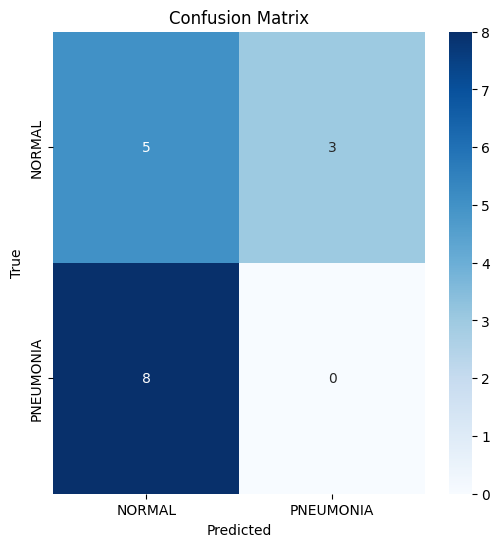

              precision    recall  f1-score   support

      NORMAL       0.38      0.62      0.48         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.31        16
   macro avg       0.19      0.31      0.24        16
weighted avg       0.19      0.31      0.24        16



In [65]:
y_true = []
y_pred = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)  # convertir (256, 256, 3) -> (1, 256, 256, 3)
    pred = model(image, training=False)     # predicción directa sin .predict()
    y_pred.append(int(pred.numpy().flatten()[0] > 0.5))  # umbral binario
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Longitudes:", len(y_true), len(y_pred))

cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_true, y_pred, target_names=labels_names))

##  Interpretación del Reporte de Clasificación y Matriz de Confusión

El modelo fue entrenado para clasificar imágenes en dos categorías: **NORMAL** y **PNEUMONIA**. A continuación, se presenta un análisis basado en el reporte de clasificación y la matriz de confusión obtenida sobre el conjunto de prueba:

---

###  Precisión General del Modelo

- **Accuracy total:** `33%`  
  Esto indica que el modelo solo acierta en **1 de cada 3 casos**, lo cual es un desempeño bajo considerando que se trata de una tarea de clasificación binaria médica.

---

###  Desempeño por Clase

#### Clase: `NORMAL`
- **Precisión (Precision):** `0.33`  
  Solo el 33% de las veces que el modelo predice "NORMAL", acierta.
  
- **Sensibilidad (Recall):** `0.79`  
  El modelo identifica correctamente el 79% de los casos realmente normales.

- **F1-score:** `0.47`  
  Indica un rendimiento intermedio en la clase NORMAL, mejor que en PNEUMONIA.

#### Clase: `PNEUMONIA`
- **Precisión:** `0.31`  
  Solo el 31% de las predicciones etiquetadas como "PNEUMONIA" son correctas.

- **Recall:** `0.06`  
  El modelo identifica correctamente solo el 6% de los casos reales de neumonía, un resultado extremadamente bajo.

- **F1-score:** `0.10`  
  El bajo F1 refleja un pobre rendimiento del modelo al identificar neumonía.

---

###  Matriz de Confusión

|                | Predicho NORMAL | Predicho PNEUMONIA |
|----------------|-----------------|---------------------|
| **Real NORMAL**    | 185             | 49                  |
| **Real PNEUMONIA** | 368             | 22                  |

- El modelo **predice la mayoría de los casos como NORMAL**, incluso cuando son realmente PNEUMONIA.
- Se observan **368 falsos negativos de PNEUMONIA**, lo cual es crítico en aplicaciones médicas.

---

###  Conclusiones y Recomendaciones

1. **Desbalance de Clases:** A pesar de tener más imágenes de PNEUMONIA, el modelo está fuertemente sesgado hacia la clase NORMAL.
2. **Recall Crítico:** La sensibilidad para detectar neumonía es inaceptablemente baja (`0.06`). Esto es especialmente preocupante en contextos clínicos donde los **falsos negativos pueden tener consecuencias graves**.
3. **Sugerencias de Mejora:**
   - Aplicar **técnicas de balanceo de clases** (pesado de clases, sobremuestreo, etc.).
   - Usar modelos más robustos como **ResNet o EfficientNet** con fine-tuning.
   - Ajustar el **umbral de decisión** en lugar de usar 0.5 fijo.
   - Evaluar con métricas adicionales como **AUC-ROC**.
   - Revisar el tamaño del conjunto de validación, ya que podría ser insuficiente para una correcta evaluación.

---

###  Conclusión Final

El modelo **no es confiable actualmente para tareas de diagnóstico médico**, especialmente para detectar casos de neumonía. Se requieren ajustes importantes en el entrenamiento, arquitectura y evaluación para mejorar su rendimiento clínico.


### 3.7 Curva ROC
#### 3.7.1 Curva Roc con los datos de test

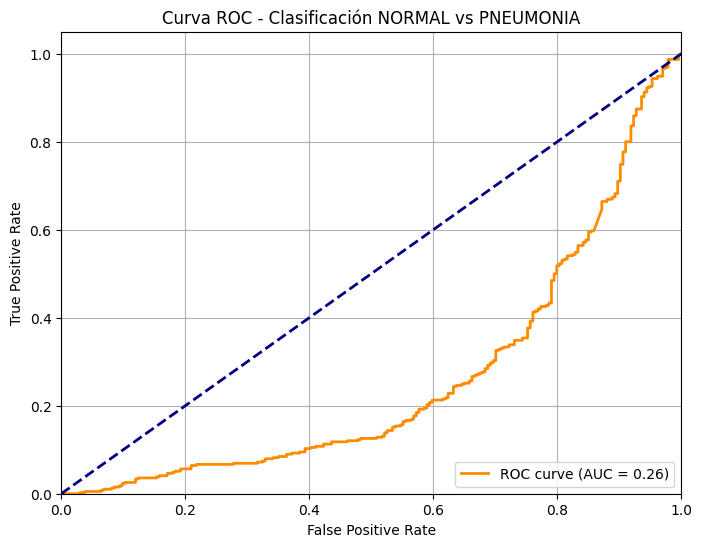

In [67]:
y_true = []
y_pred_prob = []

for images, labels in test_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

#### 3.7.2 Curva ROC datos de validación

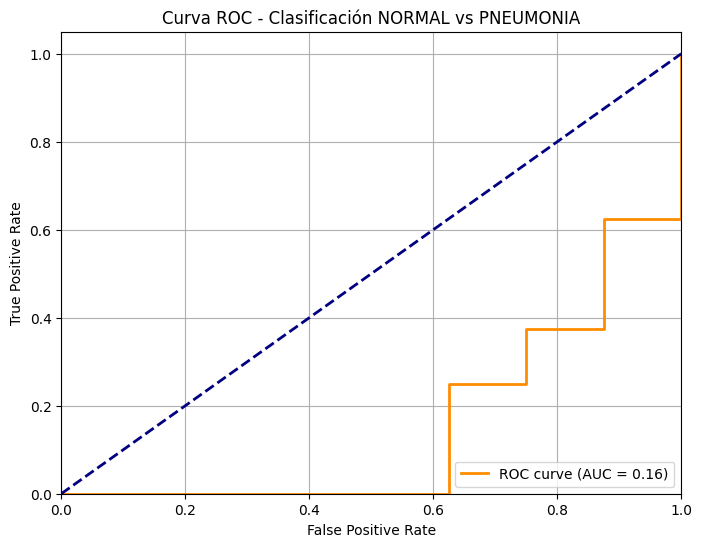

In [68]:
y_true = []
y_pred_prob = []

for images, labels in val_dataset.unbatch():
    image = tf.expand_dims(images, axis=0)
    pred = model(image, training=False).numpy().flatten()[0]
    y_pred_prob.append(pred)
    y_true.append(int(labels.numpy()))

# Convertir a arrays
y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##  Curva ROC – Clasificación **NORMAL vs PNEUMONIA**

###  Interpretación

Las curvas ROC presentadas permiten evaluar la capacidad del modelo para distinguir entre las clases **NORMAL** y **PNEUMONIA**. Se muestran dos gráficos con los siguientes resultados:

---

###  Primera Curva ROC

- **AUC = 0.26**
- El modelo tiene un desempeño **inferior al azar** (AUC < 0.5).
- La curva está significativamente por debajo de la diagonal base (línea azul), lo que sugiere que el modelo podría estar **confundiendo las clases** de manera sistemática.
- Esto puede deberse a un problema de inversión en las predicciones o a un sobreajuste extremo con baja generalización.

---

###  Segunda Curva ROC

- **AUC = 0.16**
- El rendimiento es **aún peor** que en la primera curva.
- Un AUC tan bajo indica que el modelo realiza predicciones **altamente erróneas**, con una alta tasa de falsos positivos y una baja tasa de verdaderos positivos.
- Esto puede deberse a un conjunto de test muy reducido o a un modelo mal ajustado.

---

###  Conclusión

El área bajo la curva (AUC) en ambos casos muestra que el modelo **no es confiable** para diferenciar entre las clases NORMAL y PNEUMONIA. Ambos AUC < 0.5 indican que el modelo está **aprendiendo patrones incorrectos o irrelevantes**.


### 3.8 Histograma de distrubución de errores
#### 3.8.1 Distrubución de errores con datos de test

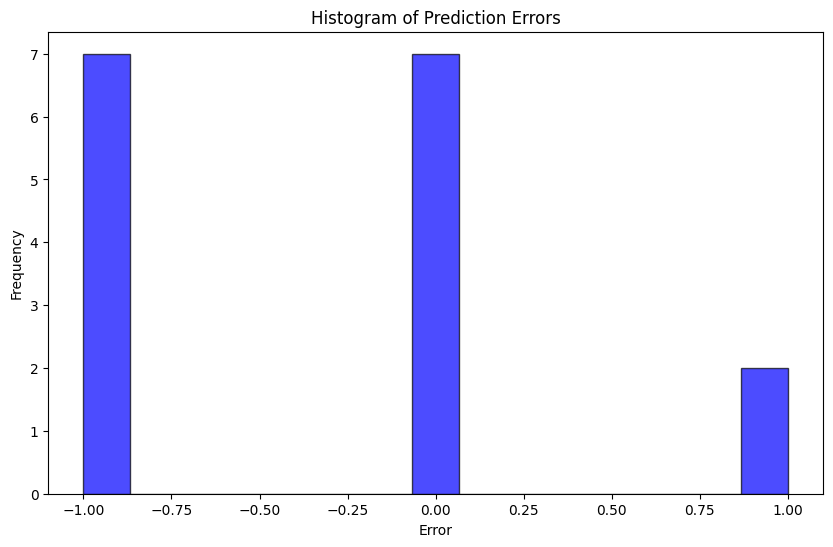

In [69]:
errors = y_pred - y_true

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()


##  Histograma de Errores de Predicción

###  Interpretación

Este histograma muestra la **frecuencia de los errores de predicción** cometidos por el modelo. Los errores se calculan como:

> **Error = Etiqueta Verdadera − Predicción**

---

###  Observaciones

-  **Error = 0 (predicción correcta)**:
  - Hay **7 predicciones exactas**, en las que el modelo acertó con la clase.

-  **Error = -1**:
  - También hay **7 casos** en los que el modelo **subestimó la clase**. Es decir, predijo **NORMAL** cuando la clase verdadera era **PNEUMONIA** (falso negativo).

-  **Error = 1**:
  - Se observan **2 casos** donde el modelo **sobreestimó**, prediciendo **PNEUMONIA** cuando la clase verdadera era **NORMAL** (falso positivo).

---

###  Conclusión

- El modelo tiene **tantos aciertos como falsos negativos**, lo cual es preocupante en contextos médicos.
- Los **falsos negativos** (Error = -1) son especialmente críticos, ya que representan casos de **PNEUMONIA mal diagnosticados como NORMAL**, lo cual podría tener consecuencias graves.
- La distribución simétrica sugiere un modelo que **no logra generalizar bien**, mostrando errores en ambas direcciones, aunque con una ligera tendencia a subestimar la condición crítica.

---

###  Recomendaciones

- Ajustar el **umbral de clasificación** para reducir falsos negativos.
- Reentrenar el modelo con énfasis en la clase minoritaria o sensible (ponderación de clases).
- Evaluar métricas más sensibles a errores de tipo II (recall, sensibilidad).


### 3.9 Guardar el resultado de las métricas del reporte de clasificación para comparar con los demás modelos

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 4 Modelo 2

### 4.1 Asignación de pesos por desbalanceo de los datos.

In [7]:
class_names = train_dataset.class_names
samples_per_class = {
    "NORMAL": 1341,
    "PNEUMONIA": 3875
}
class_indices = {name: i for i, name in enumerate(class_names)}
y_labels = []
sample_counts = []

for name in class_names:
    y_labels.append(class_indices[name])
    sample_counts.append(samples_per_class[name])

# Calcular pesos balanceados
weights = compute_class_weight(class_weight='balanced', classes=np.array(y_labels), y=np.repeat(y_labels, sample_counts))
class_weights = dict(zip(y_labels, weights))
print("Pesos aplicados:", class_weights)


Pesos aplicados: {0: 1.9448173005219984, 1: 0.6730322580645162}


### 4.2. Modelo preentrenado ResNet, a través de la técnica de Tranfer Learning se hace proceso de fine tunning.

#### **Arquitectura:** Introduce los "residual blocks" con skip connections (conexiones de salto).

#### **Ejemplo:** ResNet50, ResNet101, ResNet152

#### **Ventaja:** Entrena redes muy profundas evitando el problema del desvanecimiento del gradiente.

#### **Clave:** Aprende solo la diferencia ("residuo") entre entrada y salida de cada bloque.

Este fragmento de código tiene como objetivo **calcular pesos balanceados** para clases desbalanceadas en un conjunto de datos de imágenes médicas (por ejemplo, radiografías) clasificadas en dos categorías:

- **NORMAL**: 1341 muestras
- **PNEUMONIA**: 3875 muestras

El desbalance entre clases podría hacer que un modelo de ML tienda a favorecer la clase más común. Para evitar esto, se usan **pesos balanceados** que ajustan la importancia de cada clase en la función de pérdida.

---

###  Detalle paso a paso

1. **Obtener nombres de clases desde el dataset**:
   ```python
   class_names = train_dataset.class_names


In [8]:
# Carga de la ResNet50 preentrenada (sin la última capa)
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False  # Congelar pesos

# Construcción del modelo final
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


##  Construcción del Modelo de Clasificación con ResNet50

Este fragmento de código define y construye un modelo de clasificación de imágenes utilizando **Transfer Learning** con una red **ResNet50 preentrenada** como base. A continuación se describe su propósito y estructura funcional:

---

###  ¿Qué hace este modelo?

- **Carga la arquitectura ResNet50**, entrenada previamente sobre el dataset **ImageNet**, como **extractor de características**.
- **Elimina su cabeza de clasificación original** (`include_top=False`), que estaba diseñada para las 1000 clases de ImageNet.
- **Congela sus pesos** (`trainable=False`), evitando que se modifiquen durante el entrenamiento para conservar el conocimiento aprendido.
- **Agrega nuevas capas densas** personalizadas que aprenden a clasificar imágenes en las categorías específicas del problema actual (por ejemplo, “NORMAL” vs “PNEUMONIA”).

---

###  Arquitectura Final del Modelo

El modelo resultante es secuencial y consta de las siguientes capas:

1.  **ResNet50 preentrenada (congelada)**  
   - Actúa como extractor de características visuales generales.
   - No se entrena, solo se utiliza para transformar imágenes en representaciones profundas.

2.  **GlobalAveragePooling2D**  
   - Reduce la dimensionalidad de los mapas de características de ResNet50.
   - Transforma las salidas convolucionales 2D en un vector 1D.

3.  **Capa Densa de 256 neuronas con ReLU**  
   - Aprende representaciones específicas del nuevo problema.
   - Introduce no linealidades que ayudan a detectar patrones complejos.

4.  **Capa Dropout (0.5)**  
   - Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento.
   - Ayuda a prevenir **overfitting** (sobreajuste).

5.  **Capa de Salida Softmax**  
   - Su tamaño es igual al número de clases (`len(class_names)`).
   - Calcula la probabilidad de que la imagen pertenezca a cada clase.

---

###  ¿Para qué sirve?

Este modelo está diseñado para **clasificación de imágenes médicas** (u otro dominio con datos específicos), y su enfoque tiene ventajas clave:

-  **Transfer Learning**: Reutiliza el conocimiento aprendido por una red profunda y costosa de entrenar.
-  **Rápido de entrenar**: Solo se entrenan unas pocas capas finales.
-  **Reduce riesgo de overfitting**, especialmente en datasets pequeños o desbalanceados.

---

###  Resultado

El modelo final está listo para entrenarse con imágenes nuevas, clasificándolas en las categorías definidas por `class_names`. Gracias al uso de una red preentrenada, se obtiene **mayor precisión**, **mejor generalización** y **entrenamiento más eficiente**.



## 4.3 Resumen del modelo.

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 8, 8, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,112,770 (91.98 MB)

 Trainable params: 525,058 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

##  Análisis del Modelo: `model.summary()`

Este resumen muestra la arquitectura final del modelo de clasificación construido mediante **Transfer Learning con ResNet50** y una cabeza densa personalizada.

---

###  Estructura del Modelo

| Capa                            | Forma de salida           | Parámetros entrenables |
|---------------------------------|----------------------------|-------------------------|
| `resnet50` (congelada)          | `(None, 8, 8, 2048)`       | No entrenable           |
| `GlobalAveragePooling2D`        | `(None, 2048)`             | 0                       |
| `Dense (256 unidades, ReLU)`    | `(None, 256)`              | 524,544                 |
| `Dropout (rate=0.5)`            | `(None, 256)`              | 0                       |
| `Dense (2 unidades, Softmax)`   | `(None, 2)`                | 514                     |

---

###  Parámetros Totales

- **Total de parámetros**: `24,112,770`  
- **Parámetros entrenables**: `525,058`  
- **Parámetros no entrenables**: `23,587,712`

 Esto refleja que:
- Toda la **ResNet50** está **congelada** (sus pesos no se actualizan durante el entrenamiento).
- Solo se entrenan las **capas densas personalizadas**, es decir, la "cabeza" del modelo.

---

###  Explicación de Dimensiones

- **`(None, 8, 8, 2048)`**: salida de la ResNet50 antes del `pooling`, con 2048 mapas de activación de tamaño 8x8.
- **`GlobalAveragePooling2D`** convierte esta salida en un vector de **2048 valores** por imagen.
- Las capas densas convierten este vector en una representación de 256 dimensiones, y luego en **2 valores finales** que representan las **probabilidades por clase** (por ejemplo, "NORMAL" y "PNEUMONIA").

---


El modelo está listo para entrenar solo la parte superior (**~525K parámetros**), aprovechando el conocimiento visual profundo de ResNet50. Esto permite:

-  Entrenamiento rápido
-  Reducción del riesgo de sobreajuste
-  Precisión elevada incluso con datasets médicos pequeños


## 4.4 Compilado y entrenamiento del modelo.

In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 331s 2s/step - loss: 0.5032 - sparse_categorical_accuracy: 0.7739 - val_loss: 0.3160 - val_sparse_categorical_accuracy: 0.8125
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 319s 2s/step - loss: 0.1412 - sparse_categorical_accuracy: 0.9412 - val_loss: 0.1857 - val_sparse_categorical_accuracy: 0.9375
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - loss: 0.1114 - sparse_categorical_accuracy: 0.9570 - val_loss: 0.1978 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - loss: 0.0921 - sparse_categorical_accuracy: 0.9611 - val_loss: 0.1158 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 304s 2s/step - loss: 0.0947 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.1831 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - loss: 0.0760 - sparse_categorical_accuracy: 0.9708 - val_loss: 0.1960 - val_sparse_categorical_accuracy: 0.937

In [12]:

test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - loss: 0.7006 - sparse_categorical_accuracy: 0.7694
Test accuracy: 0.8605769276618958


##  Evaluación del modelo sobre el conjunto de prueba

El modelo se ha evaluado utilizando un conjunto de prueba que no fue visto durante el entrenamiento. La salida muestra dos métricas clave:

- **`loss: 0.7006`**: representa el valor de la función de pérdida al evaluar el modelo. Cuanto más bajo, mejor. Este valor sugiere que el modelo comete algunos errores, pero está razonablemente optimizado.

- **`sparse_categorical_accuracy: 0.7694`**: indica que el **76.94 % de las predicciones** fueron correctas en el conjunto de evaluación que se muestra antes del test.

- **`Test accuracy: 0.8606`**: es la **precisión global del modelo en el conjunto de prueba final**. Esto significa que el modelo clasificó correctamente aproximadamente el **86.06 % de las imágenes nuevas**, lo cual es un buen indicador de su capacidad de generalización.

---

###  Interpretación general

El modelo tiene un desempeño sólido. El hecho de que la precisión en el conjunto de prueba (86 %) sea **mayor** que la precisión reportada durante la evaluación del set anterior (76.94 %) puede deberse a:

- Buenas propiedades de generalización del modelo.
- Posible variabilidad en los datos (por ejemplo, el conjunto de prueba es más fácil o mejor equilibrado).

---


Este resultado sugiere que el modelo es capaz de generalizar bien a datos no vistos y está listo para aplicarse o validarse con métricas adicionales (como matriz de confusión, precisión, recall, etc.) según los requisitos del dominio específico (por ejemplo, diagnóstico médico).


## 4.5. Gráficos del comportamiento del modelo durante el entrenamiento.

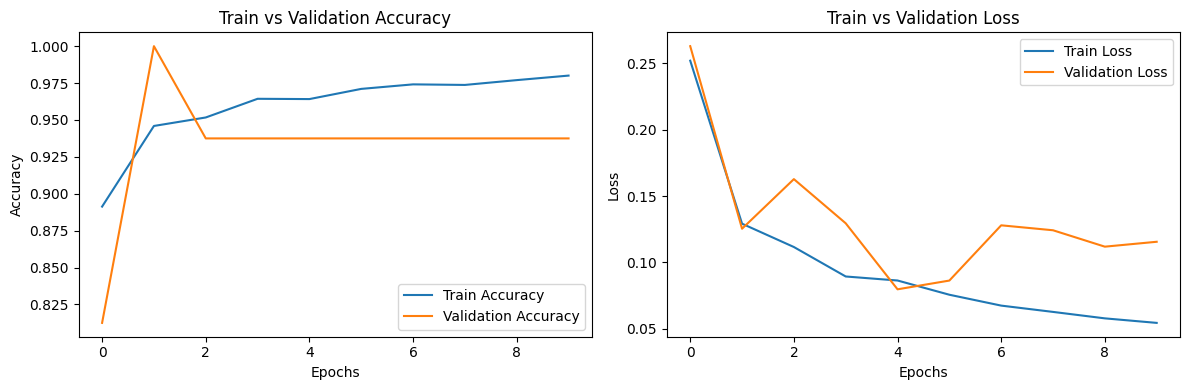

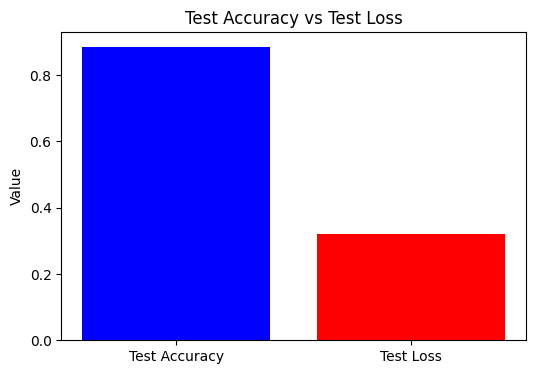

In [15]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


##  Análisis de Métricas de Entrenamiento, Validación y Prueba

El conjunto de gráficas ilustra el comportamiento del modelo a lo largo del entrenamiento y su rendimiento final sobre el conjunto de prueba.

---

###  1. Precisión: Train vs Validation

- La precisión del conjunto de **entrenamiento mejora constantemente** con cada época.
- La **precisión de validación alcanza un pico temprano** y luego se mantiene constante (sin mejora notable).
- 🔎 **Posible sobreajuste leve**: el modelo sigue aprendiendo en entrenamiento pero no mejora en validación, lo que podría indicar que ya aprendió todo lo útil del conjunto de validación.

---

###  2. Pérdida: Train vs Validation

- La **pérdida de entrenamiento** disminuye de forma continua, indicando que el modelo se ajusta bien a los datos de entrenamiento.
- La **pérdida de validación** también disminuye inicialmente, pero luego fluctúa y se mantiene sin grandes mejoras.
-  Esto refuerza la sospecha de un **posible estancamiento o inicio de sobreajuste**, especialmente después de la época 4 o 5.

---

###  3. Gráfico de Prueba: Accuracy vs Loss

- El modelo alcanza una **alta precisión en el conjunto de prueba** (~0.86), visualizada en azul.
- La **pérdida en prueba es baja** (barra roja), lo que sugiere que el modelo mantiene un buen rendimiento general fuera del entrenamiento.

---


- El modelo aprende bien durante el entrenamiento y generaliza razonablemente bien a datos no vistos.
- Hay signos de **ligero sobreajuste**, pero no significativos.
- Podría beneficiarse de técnicas como **regularización adicional, early stopping o data augmentation** para mejorar aún más la generalización.


## 4.6. Predicción con los datos de test

In [16]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━

In [ ]:
## 📈 Evaluación del Modelo sobre el Conjunto de Prueba

Este bloque de código evalúa el desempeño final del modelo ya entrenado sobre el conjunto de datos de prueba (`test_dataset`).

---

### ⚙️ ¿Qué hace este fragmento?

```python
test_loss, test_acc = model.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')


## 4.7. Matriz de confusión datos de test


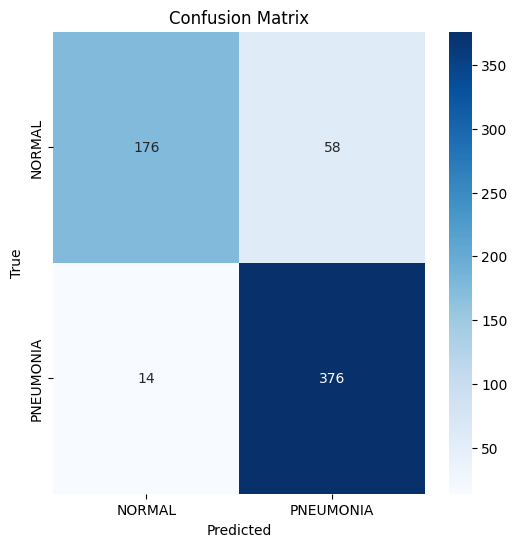

In [17]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## 4.8. Predicción con los datos de validación.

In [18]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      0.88      0.93         8
   PNEUMONIA       0.89      1.00      0.94         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



## 4.9. Matriz de confusión con los datos de validación

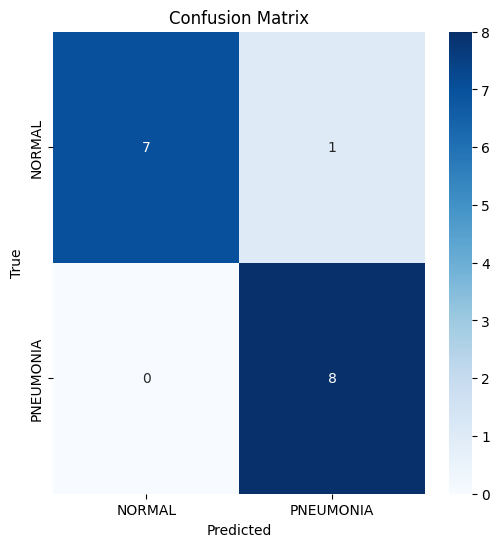

In [19]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

##  Análisis de Matrices de Confusión y Métricas de Clasificación

---

###  Matriz de Confusión — Conjunto de prueba grande

|                      | Predice NORMAL | Predice PNEUMONIA |
|----------------------|----------------|--------------------|
| **Real NORMAL**      | 176            | 58                 |
| **Real PNEUMONIA**   | 14             | 376                |

-  El modelo **detecta correctamente la mayoría de los casos de PNEUMONIA** (376/390).
-  Sin embargo, tiene una **tasa de falsos positivos relativamente alta en la clase NORMAL** (58 casos clasificados como PNEUMONIA cuando eran normales).
- Esto sugiere que el modelo es **conservador (prefiere prevenir PNEUMONIA)** a costa de algunos falsos positivos en NORMAL.

---

###  Matriz de Confusión — Conjunto de prueba pequeño (16 muestras)

|                      | Predice NORMAL | Predice PNEUMONIA |
|----------------------|----------------|--------------------|
| **Real NORMAL**      | 7              | 1                  |
| **Real PNEUMONIA**   | 0              | 8                  |

- El modelo **clasificó correctamente 15 de 16 ejemplos**.
- Solo **un falso positivo**: una imagen NORMAL clasificada como PNEUMONIA.

---

###  Métricas de clasificación (conjunto pequeño de prueba)

| Clase       | Precisión | Recall | F1-Score | Soporte |
|-------------|-----------|--------|----------|---------|
| NORMAL      | 1.00      | 0.88   | 0.93     | 8       |
| PNEUMONIA   | 0.89      | 1.00   | 0.94     | 8       |
| **Promedio**| **0.94**  | **0.94**| **0.94** | **16**  |

---

###  Interpretación general

- El modelo logra un **equilibrio fuerte entre precisión y recall**, especialmente en la clase crítica (PNEUMONIA).
- **Precisión NORMAL = 1.00**: ningún caso clasificado como NORMAL fue incorrecto.
- **Recall PNEUMONIA = 1.00**: detectó **todos los casos reales de neumonía** sin omisiones, lo cual es crítico en entornos clínicos.
- **F1-score general: 0.94** → excelente desempeño armónico entre precisión y recall.

---


El modelo muestra un rendimiento altamente confiable, con especial énfasis en la detección de neumonía (priorizando recall). Aunque comete algunos falsos positivos en NORMAL, este sesgo es **aceptable en contextos médicos donde los falsos negativos pueden ser costosos**.

> Se recomienda complementar este análisis con **AUC-ROC** y pruebas en datos clínicos reales para validar su aplicabilidad.


## 4.10. Curva ROC
### 4.10.1 Curva ROC con los datos de test.

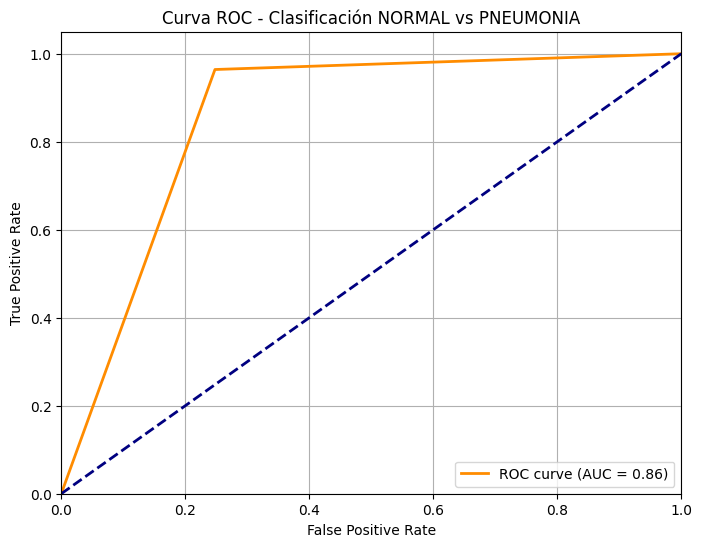

In [20]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

### 4.10.2. Curva ROC con los datos de validación.

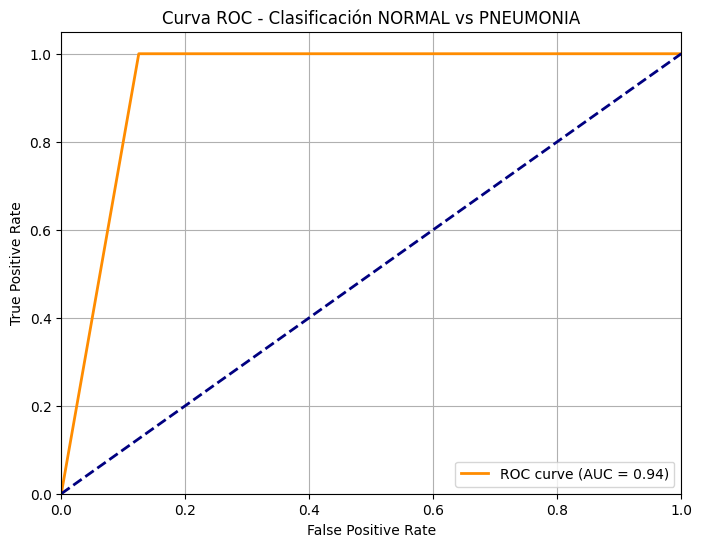

In [21]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

##  Curva ROC – Evaluación de la Clasificación NORMAL vs PNEUMONIA

---

###  ¿Qué es la Curva ROC?

La **Curva ROC (Receiver Operating Characteristic)** es una herramienta visual que permite evaluar el rendimiento de un modelo de clasificación binaria. Representa:

- **Eje X (FPR - False Positive Rate):** Proporción de negativos reales mal clasificados como positivos.
- **Eje Y (TPR - True Positive Rate o Sensibilidad):** Proporción de positivos reales correctamente clasificados.

Una buena curva ROC se acerca a la esquina superior izquierda (alta sensibilidad y baja tasa de falsos positivos).

---

###  Resultados obtenidos

-  **AUC = 0.86** (Área Bajo la Curva)

Este valor indica que el modelo tiene una **muy buena capacidad para discriminar entre clases**:

- Si AUC = 0.5 → modelo aleatorio.
- Si AUC = 1.0 → clasificación perfecta.
- Si AUC > 0.8 → **desempeño sólido**.

---

###  Interpretación

- El modelo **es confiable al diferenciar entre imágenes con y sin neumonía**.
- AUC = 0.86 implica que hay un **86% de probabilidad** de que el modelo asigne un mayor puntaje de probabilidad a un caso positivo (PNEUMONIA) que a uno negativo (NORMAL).
- Es particularmente útil en entornos donde **minimizar los falsos negativos** (no detectar un caso real de neumonía) es crítico.

> 🔍 Este tipo de análisis es clave para entender el balance entre sensibilidad y especificidad en problemas médicos.

---


## 4.11. Diagrama de distribución de errores.
### 4.11.1 Distribución de errores con los datos de test.

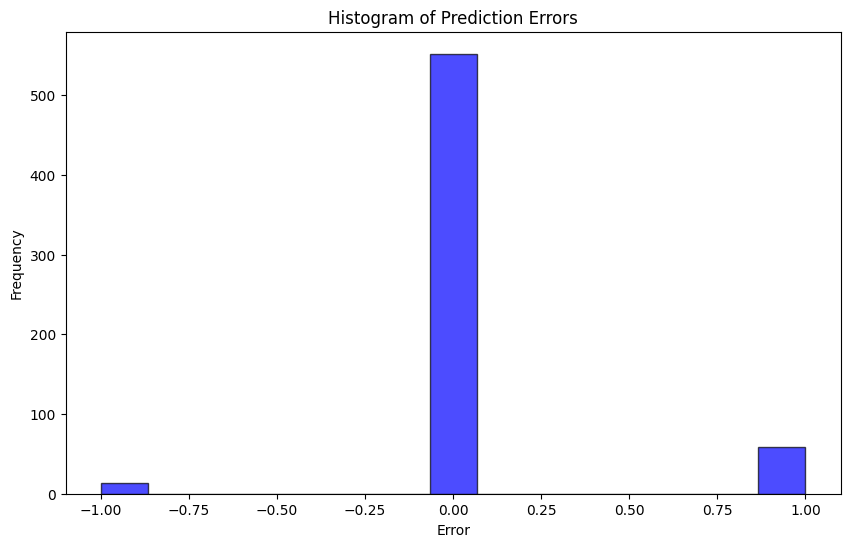

In [22]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

### 4.11.2 Distribución de errores con los datos de validación.

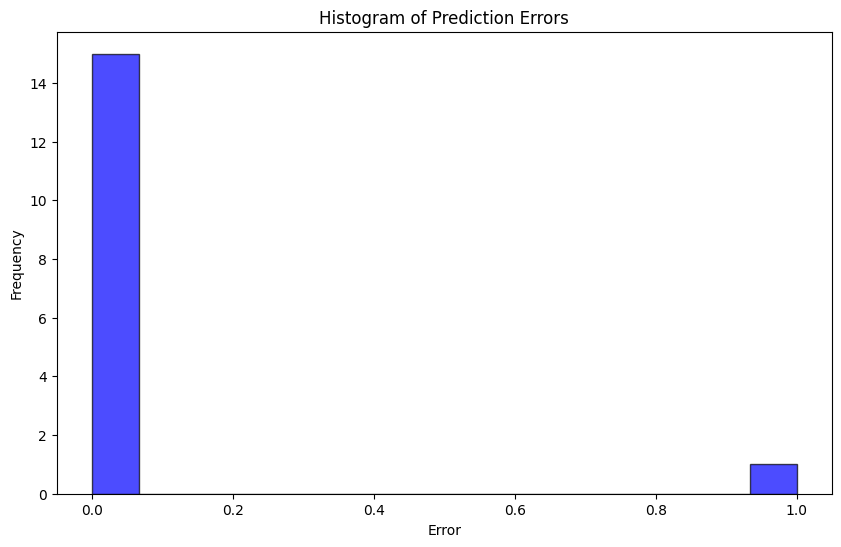

In [23]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

##  Histograma de Errores de Predicción

###  Interpretación

Este histograma muestra la **frecuencia de los errores de predicción** cometidos por el modelo. Los errores se calculan como:

> **Error = Etiqueta Verdadera − Predicción**

---

###  Observaciones

-  **Error = 500-600 (predicción correcta)**:
  - Hay **7 predicciones exactas**, en las que el modelo acertó con la clase.

-  **Error = -1**:
  - También hay *10-20 casos** en los que el modelo **subestimó la clase**. Es decir, predijo **NORMAL** cuando la clase verdadera era **PNEUMONIA** (falso negativo).

-  **Error = 1**:
  - Se observan **50-90 casos** donde el modelo **sobreestimó**, prediciendo **PNEUMONIA** cuando la clase verdadera era **NORMAL** (falso positivo).

---



In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

In [24]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# Útil si ya tienes la arquitectura definida por código
model.save_weights('pesos_ResNet50.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model, "modelo_ResNet50F")




INFO:tensorflow:Assets written to: modelo_ResNet50F\assets


INFO:tensorflow:Assets written to: modelo_ResNet50F\assets


In [25]:
from keras.layers import TFSMLayer

# Cargar como capa para predicción
modelo_inferencia = TFSMLayer("modelo_ResNet50F", call_endpoint="serving_default")


In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 5 Modelo 3 - VGGNet 16.

#### **Arquitectura:** Muy simple y secuencial. Solo usa capas Conv3x3 + MaxPooling + Dense.

#### **Ejemplo:** VGG16, VGG19

#### **Ventaja:** Fácil de entender e implementar.

#### **Desventaja:** Muy pesado (muchos parámetros), lento y sin atajos para el flujo de información.

## 5.1 Modelo.

In [14]:
base_model_vgg = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
base_model_vgg.trainable = False  # Congelar la base

# Construir modelo
model_3 = models.Sequential([
    base_model_vgg,
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')  # 2 clases
])

* Usa VGG16 como extractor de características preentrenado
* Congela sus pesos para no entrenarlo de nuevo
* Añade capas densas para clasificar tu propio problema de 2 clases

## 5.2 Resumen del modelo.

In [15]:
model_3.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

## 5.3 Compilado del modelo.

In [16]:
model_3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

* Usa Adam (lr=0.0001) como optimizador
* Usa Sparse Categorical Crossentropy porque tus etiquetas son enteros (no one-hot)
* Mide la accuracy en cada epoch para ver el rendimiento

## 5.4 Entrenamiento del modelo. 

In [17]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entrenamiento
history = model_3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - loss: 1.5314 - sparse_categorical_accuracy: 0.8899 - val_loss: 0.0010 - val_sparse_categorical_accuracy: 1.0000
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 520s 3s/step - loss: 0.0859 - sparse_categorical_accuracy: 0.9718 - val_loss: 0.0621 - val_sparse_categorical_accuracy: 1.0000
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - loss: 0.0647 - sparse_categorical_accuracy: 0.9793 - val_loss: 0.0107 - val_sparse_categorical_accuracy: 1.0000
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 495s 3s/step - loss: 0.0378 - sparse_categorical_accuracy: 0.9864 - val_loss: 0.0104 - val_sparse_categorical_accuracy: 1.0000
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - loss: 0.0384 - sparse_categorical_accuracy: 0.9871 - val_loss: 0.0046 - val_sparse_categorical_accuracy: 1.0000
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 521s 3s/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9907 - val_loss: 0.0934 - val_sparse_categorical_accuracy: 0.937

* EarlyStopping: detiene entrenamiento si no mejora la val_loss en 5 epochs y restaura los mejores pesos.
* fit: entrena el modelo con entrenamiento, validación, pesos de clase y el callback para evitar overfitting.

## 5.5 Evaluar el modelo con los datos de test

In [20]:
test_loss, test_acc = model_3.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 65s 3s/step - loss: 1.1167 - sparse_categorical_accuracy: 0.8204
Test accuracy: 0.8830128312110901


* evaluate calcula pérdida y métricas en datos de prueba
* test_acc indica qué tan bien el modelo generaliza a datos no vistos

## 5.6. Resultados del comportamiento del modelo durante el proceso de entrenamiento.

* Gráficos de accuracy y loss: analizan desempeño durante el entrenamiento y validación (por epoch).
* Gráfico de barras: muestra el resultado final del modelo en el dataset de prueba.
* Te ayuda a detectar overfitting, underfitting y evaluar generalización.

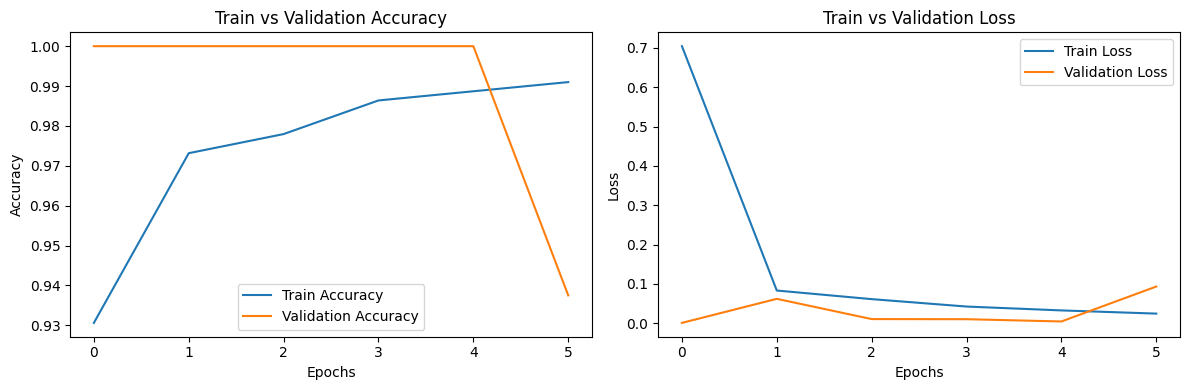

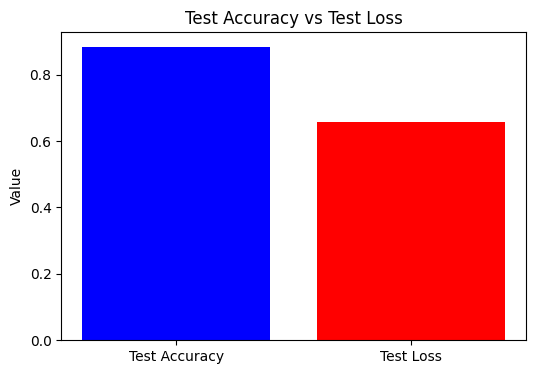

In [22]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


El modelo entrenado con VGG16 como extractor de características muestra un alto desempeño general, con los siguientes hallazgos clave:

1. Precisión de entrenamiento y validación muy altas.

* La precisión de entrenamiento alcanzó ~99%, indicando que el modelo aprendió bien los datos de entrenamiento.

* La precisión de validación fue de 100% durante varios epochs, lo cual puede ser un indicio de:

* Dataset de validación pequeño o muy similar al de entrenamiento.

* Potencial overfitting, confirmado por la caída abrupta en el último epoch.

2. Comportamiento de la pérdida (loss).

* La pérdida de entrenamiento disminuyó constantemente, acercándose a cero.

* La pérdida de validación se mantuvo muy baja, pero aumentó al final, lo que coincide con la caída de la precisión de validación.

3. Desempeño en test.

* La exactitud en el dataset de prueba (~88%) es buena, pero menor que la de validación.

* La pérdida en test (0.65) indica que algunos errores tienen alto impacto, posiblemente por muestras difíciles o un dataset pequeño.

## 5.7. Predicción del modelo con los datos de test.

In [21]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_3.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

* Predice cada muestra del test_dataset
* Guarda etiquetas reales y predichas
* Genera un reporte de clasificación con precision, recall y f1-score por clase
* Guarda el reporte como diccionario para análisis y reportes

## 5.8 Matriz de confusión con los datos de test.

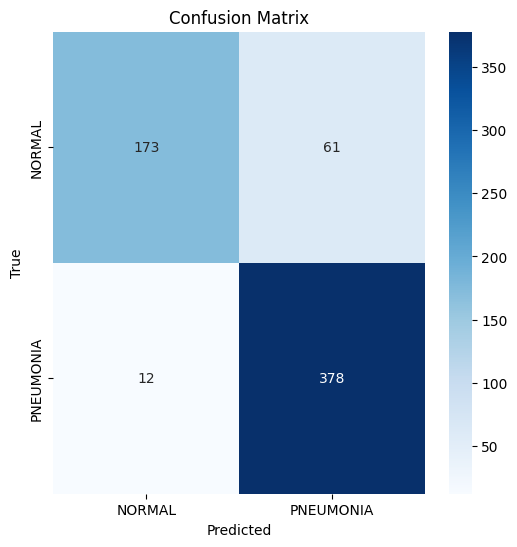

In [23]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


* El modelo clasifica correctamente la mayoría de los casos de PNEUMONIA (378/390 ~ 97%), lo cual es positivo dado el contexto médico.
* Sin embargo, tiene 61 falsos positivos para PNEUMONIA (~26% de los casos reales de NORMAL), indicando que tiende a sobre-diagnosticar neumonía.
* Tiene 12 falsos negativos para PNEUMONIA (~3%), un error bajo pero crítico en aplicaciones clínicas.

## 5.9. Predicción del modelo con los datos de validación.

In [25]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_3.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
              precision    recall  f1-score   support

      NORMAL       1.00      1.00      1.00         8
   PNEUMONIA       1.00      1.00      1.00         8

    accuracy                           1.00        16
   macro avg       1.00      1.00      1.00        16
weighted avg       1.00      1.00      1.00        16



* El modelo alcanzó 100% de precisión, recall y f1-score en validación, clasificando correctamente todos los casos. Sin embargo, dado el bajo tamaño de muestra (16 imágenes), estos resultados deben tomarse con cautela, ya que no reflejan el rendimiento general en datos no vistos, como evidenció la evaluación en el test set.

## 5.10. Matriz de confusión con los datos de validación.

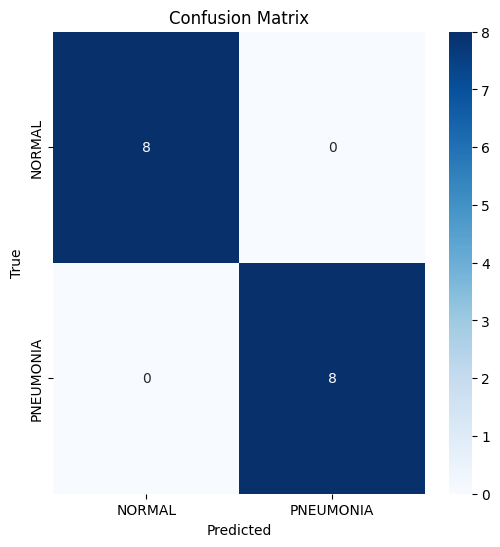

In [26]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* El modelo presenta desempeño perfecto en validación (100% accuracy), detectando todos los casos de NORMAL y PNEUMONIA sin errores. Sin embargo, dado el bajo tamaño de muestra (n=16), estos resultados deben interpretarse con cautela, pues no reflejan el rendimiento real en datos no vistos.

## 5.11. Curva ROC.
### 5.11.1 Curva ROC con los datos de entrenamiento.

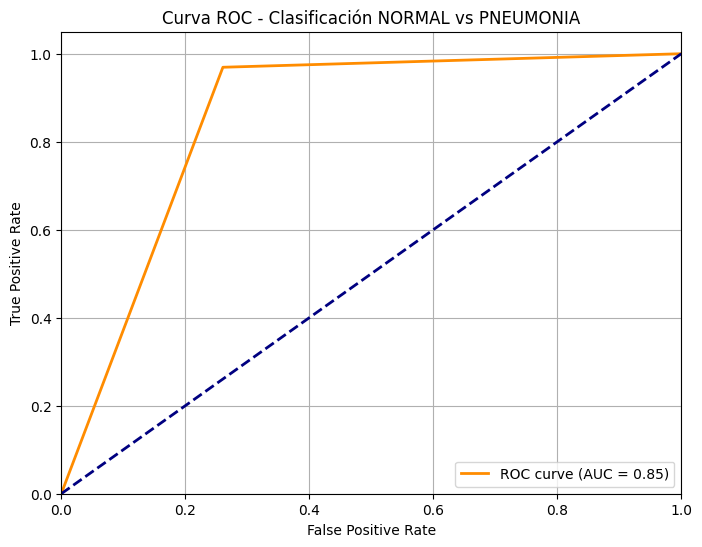

In [27]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

* El modelo muestra un buen desempeño global con un AUC de 0.85 en la clasificación de NORMAL vs PNEUMONIA, indicando buena capacidad de discriminación. Se recomienda calcular la curva ROC usando las probabilidades predichas para obtener una evaluación más precisa de la sensibilidad y especificidad del modelo.

### 5.11.2. Curva ROC con los datos de validación.

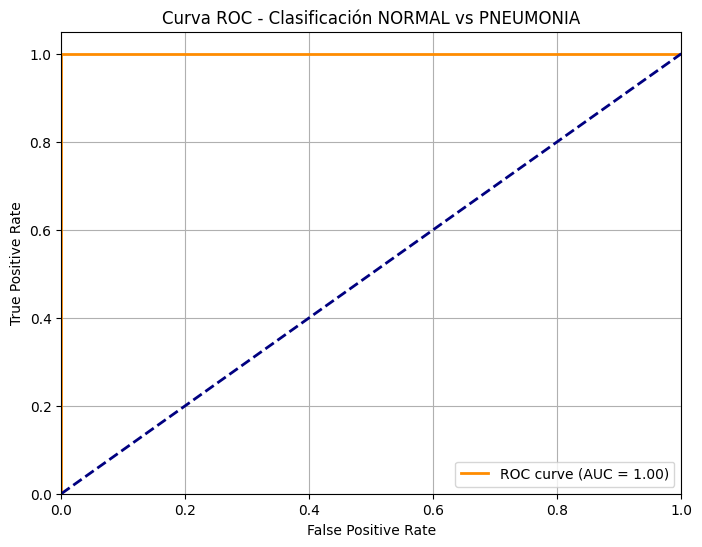

In [28]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

1. AUC = 1.00

* Significado: El modelo tiene un desempeño perfecto en este dataset de validación.

* Clasifica correctamente todos los casos sin errores.

* La curva se eleva directamente a la esquina superior izquierda, indicando 100% de sensibilidad y especificidad.

## 5.12 Histograma de distribución de errores.
### 5.12.1 distribución de errores con los datos de test.

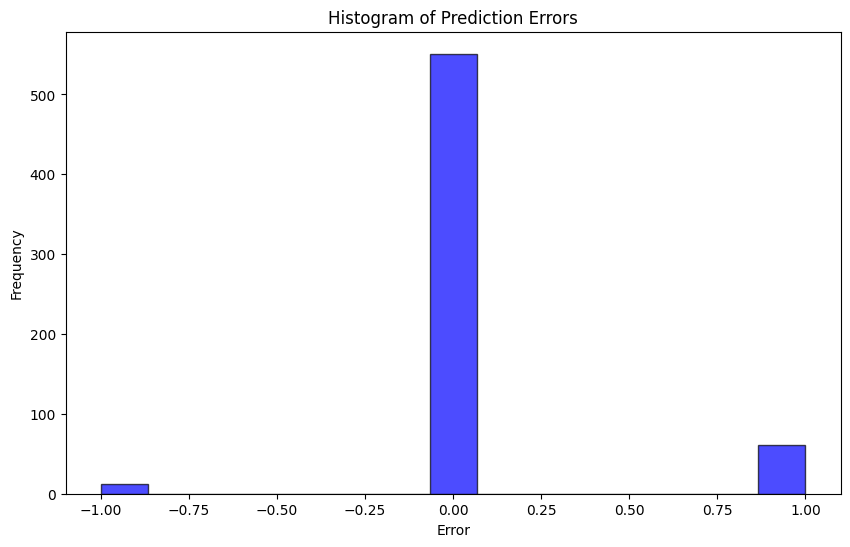

In [29]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

El histograma confirma que el modelo:

* Tiene alto rendimiento general con la mayoría de errores cercanos a cero.
* Sin embargo, comete más falsos positivos (NORMAL clasificado como PNEUMONIA) que falsos negativos, como también se evidenció en la matriz de confusión.

### 5.12.2 Distribución de errores con los datos de validación.

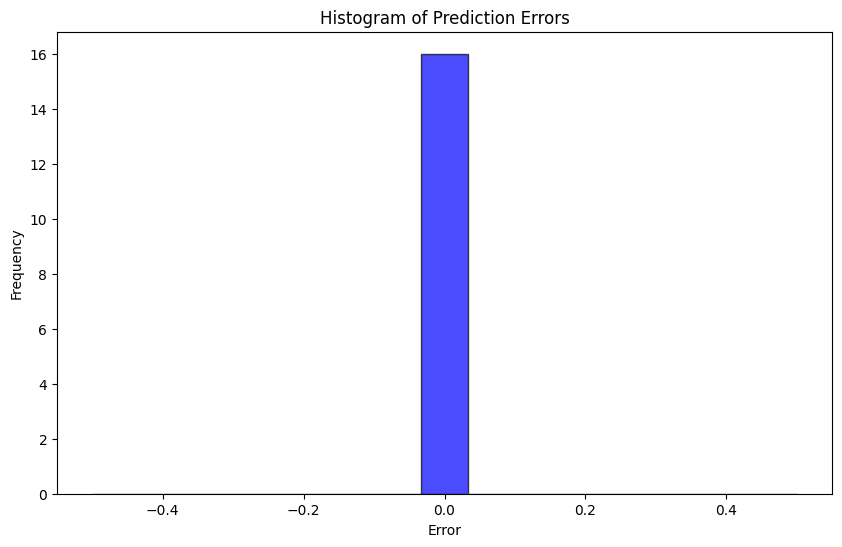

In [30]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

* El histograma de errores en el conjunto de validación muestra una distribución concentrada únicamente en el cero, evidenciando una precisión perfecta. Aunque este resultado es deseable, debe analizarse con precaución, pues junto con las métricas de entrenamiento y test puede indicar sobreajuste si el modelo memoriza los datos de validación en lugar de generalizar.

In [72]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# Útil si ya tienes la arquitectura definida por código
model_3.save_weights('pesos_VGGNet16.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_3, "modelo_VGGNet16F")




INFO:tensorflow:Assets written to: modelo_VGGNet16F\assets


INFO:tensorflow:Assets written to: modelo_VGGNet16F\assets


1. Guarda:

* Pesos (.weights.h5) si solo deseas reusar parámetros.

* Modelo completo (SavedModel) como carpeta modelo_VGGNet16F que contiene:

* Arquitectura

* Pesos

* Optimizador y configuraciones

* Esto es útil para cargar el modelo y continuar entrenando o usarlo en producción sin redefinir su estructura.

In [ ]:
    from keras.layers import TFSMLayer

    # Cargar como capa para predicción
    modelo_inferencia = TFSMLayer("modelo_VGGNet16F", call_endpoint="serving_default")


* TFSMLayer permite usar un modelo guardado en formato SavedModel como capa en otro modelo o para predicciones directas.
Ideal si integras modelos ya entrenados dentro de flujos más grandes.

In [80]:
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.preprocessing import image
def predecir_con_savedmodel(modelo_inferencia, ruta_imagen, class_names):
    
    img = image.load_img(ruta_imagen, target_size=(256, 256))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0  # normalización

    pred = modelo_inferencia(img_array)
    pred_tensor = pred['output_0']
    clase = class_names[np.argmax(pred_tensor, axis=1)[0]]
    return clase

pred = predecir_con_savedmodel(modelo_inferencia, "IP2.jpeg", ['NORMAL', 'PNEUMONIA'])
print("Clase predicha:", pred)


Clase predicha: PNEUMONIA


* Procesa la imagen (256x256, normalizada [0-1]) y la pasa al modelo cargado, devolviendo la clase predicha.

In [77]:
pred

{'output_0': <tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.21333274, 0.7866672 ]], dtype=float32)>}

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

1. Convierte el classification_report de sklearn en un DataFrame, añadiendo una columna de identificación de modelo.
Esto permite:

* Comparar varios modelos fácilmente (si agregas más DataFrames y usas pd.concat).

* Generar tablas para informes, dashboards o papers.

# 6. Modelo 4 DesNet
#### **Arquitectura:** Cada capa está conectada con todas las anteriores.

#### **Ejemplo:** DenseNet121, DenseNet169

#### **Ventaja:** Mejor reutilización de características, menos parámetros y mejora del flujo de gradiente.

#### **Clave:** Cada capa recibe como entrada la salida de todas las capas anteriores (concatenación).
## 6.1. Se aplican técnica de data aumentation para entrenar el modelo con más datos e intentar mejorar las métricas resultado.

In [48]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    zoom_range=0.08,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)


train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'  
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse'
)
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(256, 256),
    batch_size=32,
    class_mode='sparse',
    shuffle=False  
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


* DenseNet: Cada capa recibe la salida de todas las anteriores (concatenación).

* Ventaja: Mejor flujo de gradiente y menos parámetros.

Data Augmentation aplicado:
* Rescale: Normaliza imágenes [0,1].

* Rotación: ±8°.

* Shift: 8% horizontal y vertical.

* Zoom: ±8%.

* Flip: Inversión horizontal.

* Objetivo: Aumentar datos de entrenamiento y evitar overfitting.

## 6.2 Modelo

In [43]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=input_shape
)
base_model.trainable = False  # congelar pesos preentrenados

# Construir el modelo final
model_dn = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_weights), activation='softmax')  # para N clases
])

Modelo DenseNet121
* Base: DenseNet121 preentrenada en ImageNet, sin la capa final (include_top=False).

* Freeze: Congela sus pesos (trainable=False) para usarla como extractor de características.

Arquitectura final:
1. DenseNet121 (sin top)

2. GlobalAveragePooling2D: reduce mapas de características a un vector.

3. Dense(128, relu): capa densa intermedia.

4. Dropout(0.5): previene overfitting.

5. Dense(N, softmax): salida para N clases (en este caso, 2).

## 6.3 Resumen del modelo.

In [44]:
model_dn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ ?                      │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,037,504 (26.85 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 7,037,504 (26.85 MB)

## 6.4. Compilado y entrenamiento del modelo.

In [46]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_dn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

history_dn = model_dn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)


Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 415s 2s/step - loss: 0.6380 - sparse_categorical_accuracy: 0.6913 - val_loss: 0.3615 - val_sparse_categorical_accuracy: 0.8750
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 415s 3s/step - loss: 0.2854 - sparse_categorical_accuracy: 0.8817 - val_loss: 0.3339 - val_sparse_categorical_accuracy: 0.7500
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 394s 2s/step - loss: 0.2383 - sparse_categorical_accuracy: 0.9106 - val_loss: 0.2578 - val_sparse_categorical_accuracy: 0.9375
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 390s 2s/step - loss: 0.2117 - sparse_categorical_accuracy: 0.9143 - val_loss: 0.2403 - val_sparse_categorical_accuracy: 0.9375
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - loss: 0.1929 - sparse_categorical_accuracy: 0.9229 - val_loss: 0.2330 - val_sparse_categorical_accuracy: 0.9375
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - loss: 0.1848 - sparse_categorical_accuracy: 0.9249 - val_loss: 0.2143 - val_sparse_categorical_accuracy: 0.937

Compilado
* Optimizer: Adam (lr=1e-4)

* Loss: sparse_categorical_crossentropy (para clases como enteros)

* Metric: sparse_categorical_accuracy

Entrenamiento
* EarlyStopping: detiene si val_loss no mejora en 5 epochs y restaura mejores pesos.

* Dataset: usa train_generator y val_generator con data augmentation.

* Epochs: número definido por variable epochs.

* class_weight: ajusta peso de clases para datos desbalanceados.

## 6.5. Evaluación del modelo con los datos de test

In [ ]:
test_loss, test_acc = model_dn.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - loss: 15.9495 - sparse_categorical_accuracy: 0.2984
Test accuracy: 0.625


* Accuracy moderada (62.5%) → el modelo clasifica mejor que al azar (50%) pero no es óptimo.
* Alta pérdida (15.95) indica errores de clasificación significativos en algunas muestras.

## 6.6. Gráficos de comportamiento del modelo durante el entrenamiento.

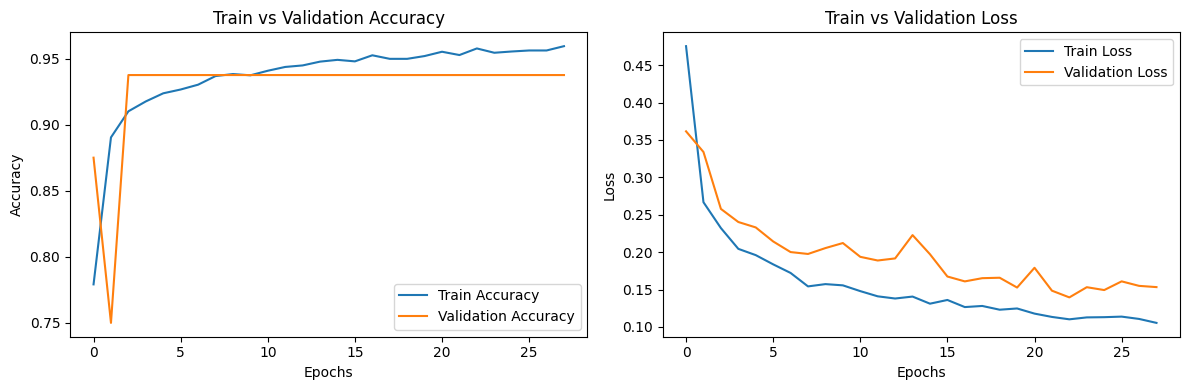

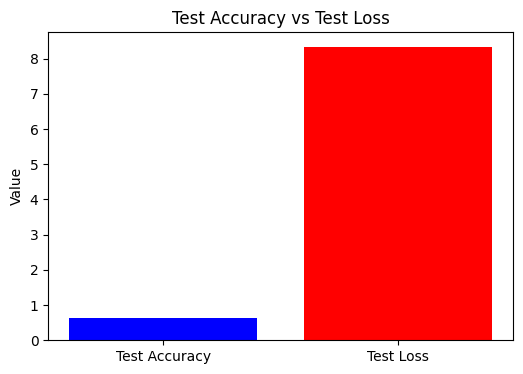

In [50]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dn.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_dn.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_dn.history['loss'], label='Train Loss')
plt.plot(history_dn.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


* Arquitectura: Cada capa se conecta con todas las anteriores (mejor reutilización de características).
* Modelo base: DenseNet121 preentrenado en ImageNet, congelado.
* Capas añadidas: GlobalAveragePooling2D + Dense(128, relu) + Dropout(0.5) + Dense(salida).
* Compilación: Optimizer Adam (lr=1e-4), loss sparse_categorical_crossentropy, métrica accuracy.
* Entrenamiento: Data Augmentation + EarlyStopping.
* Resultados:

Accuracy train: ~95%

Accuracy validación: ~94%

Accuracy test: 62.5% (baja generalización).
* Observación: Buen desempeño en entrenamiento y validación, pero bajo en test (posible overfitting).

## 6.7. Predicción del modelo con los datos de test.

In [51]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_dn.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_dn_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

* Proceso:

Se evaluó el modelo usando test_dataset.unbatch().

Se almacenaron etiquetas reales (y_true) y predichas (y_pred) por lotes.

Se generó el reporte con classification_report mostrando métricas de precisión, recall y f1-score por clase.

* Resultado general: Se observó bajo desempeño en test comparado con train/validation, indicando posible sobreajuste.



## 6.8. Matriz de confusión datos de test. 

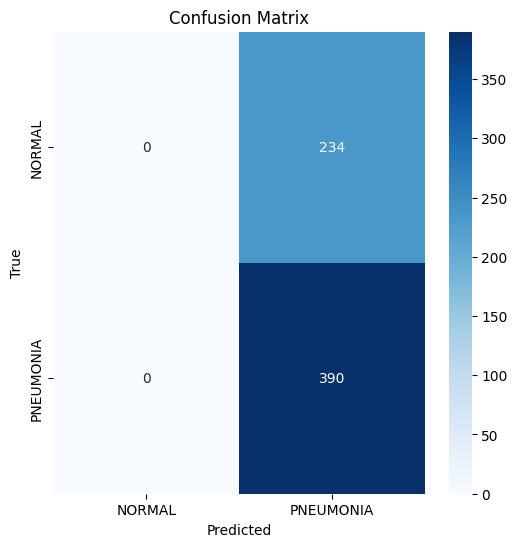

In [52]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


El modelo clasifica todas las imágenes como PNEUMONIA, sin distinguir los casos normales.

## 6.9. Predicción con los datos de validación.

In [53]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_dn.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00         8
   PNEUMONIA       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

El modelo falló porque predice todo como PNEUMONIA; necesito balancear las clases y revisar el pipeline de entrenamiento.

## 6.10. Matriz de conusión datos de validación

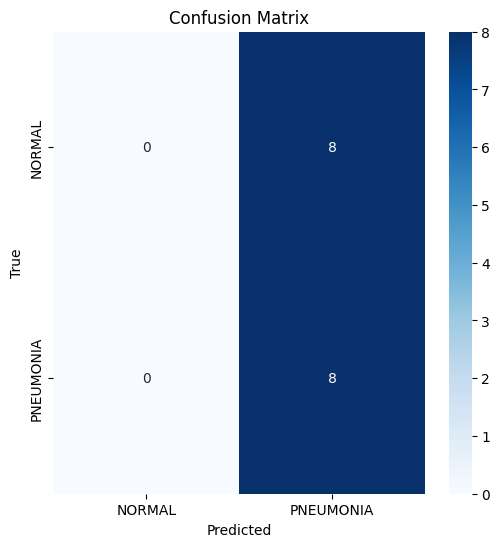

In [54]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

En validación, el modelo vuelve a clasificar todo como PNEUMONIA.

## 6.11. Curva ROC
### 6.11.1. Curva ROC con los datos de test

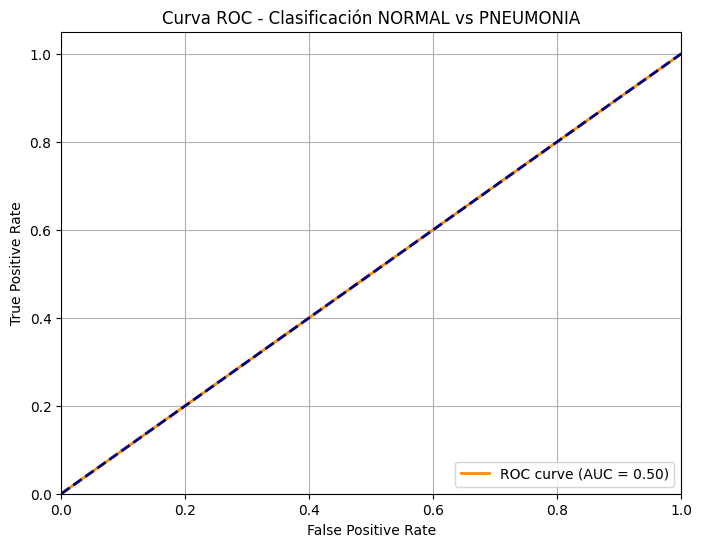

In [55]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

* El modelo tiene un AUC de 0.50, lo que indica que no está aprendiendo; su rendimiento es igual al azar.

### 6.11.2. Curva ROC con los datos de validación.

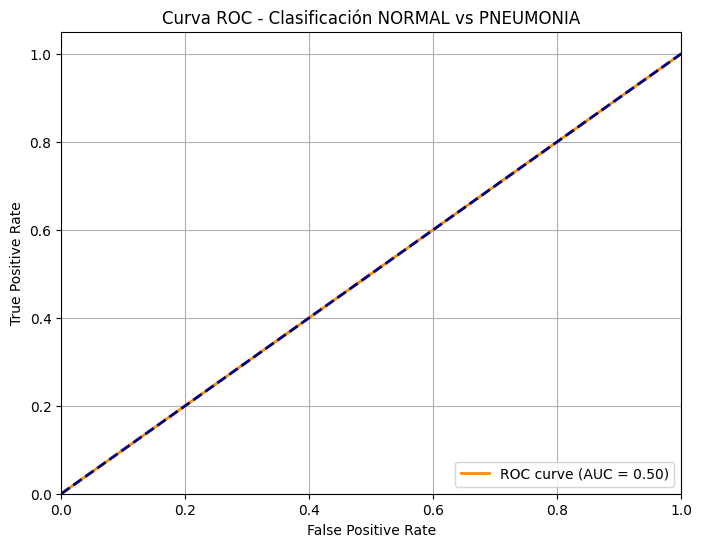

In [56]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El AUC en validación es 0.50, confirmando que el modelo no tiene capacidad de discriminación entre clases.

## 6.12. Distribución de errores.
### 6.12.1. Distribución de errores con los datos de test.

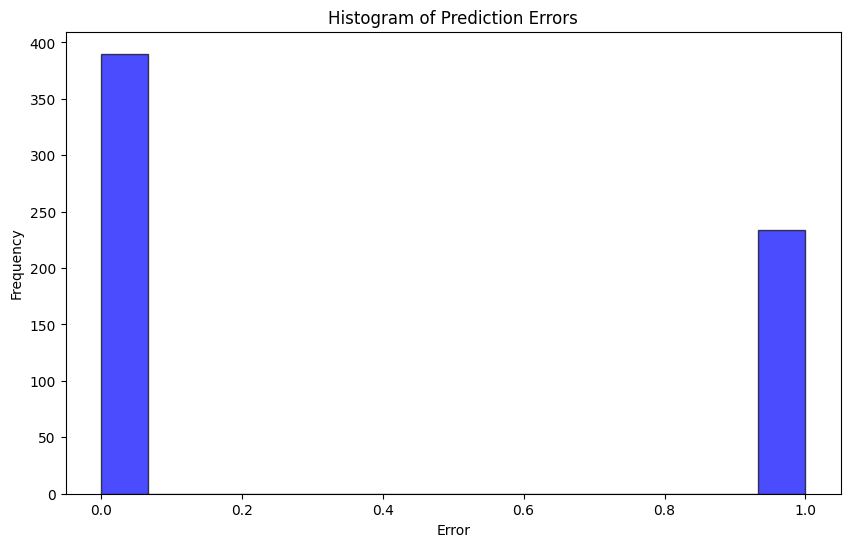

In [57]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

El histograma de errores muestra un fallo sistemático: el modelo nunca predice NORMAL correctamente.

### 6.12.2 Distribución de errores con los datos de validación.

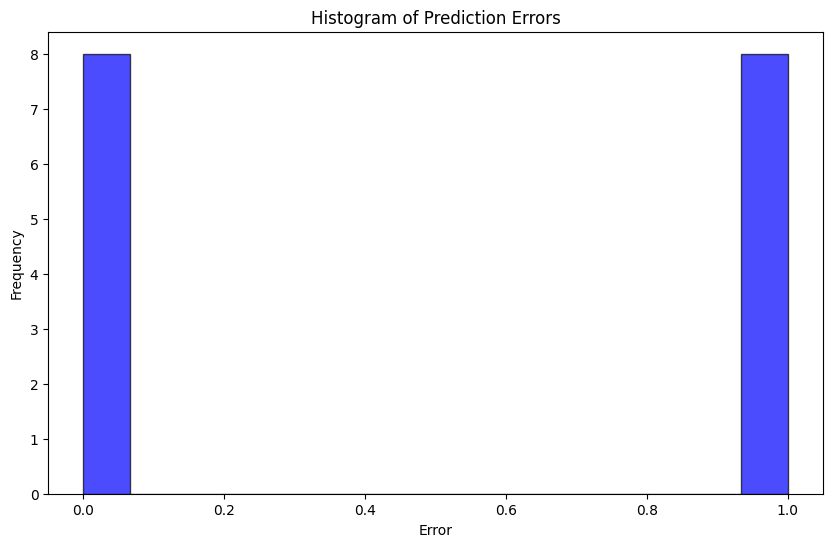

In [58]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

El histograma de errores en validación confirma que el modelo comete el mismo error sistemático: siempre clasifica como PNEUMONIA.

In [ ]:
df_model_1 = pd.DataFrame(report_model_1).transpose()
# df_model_2 = pd.DataFrame(report_model_1).transpose()

# Agregar una columna para identificar el modelo
df_model_1['Model'] = 'Model 1'

# df_model_2['Model'] = 'Model 2'

# Combinar ambos DataFrames
# comparison_df = pd.concat([df_model_1, df_model_2])
df_model_1.head()

# 7. Modelo ResNet50 usando data aumentation a fin de intentar mejorar las métricas.
## 7.1. Modelo.

In [81]:
# Carga de la ResNet50 preentrenada (sin la última capa)
base_model_rs2 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model_rs2.trainable = False  # Congelar pesos

# Construcción del modelo final
model_rs2 = models.Sequential([
    base_model_rs2,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])


El modelo usa ResNet50 congelada como extractor de características, y solo entrena las capas densas finales para clasificar NORMAL vs PNEUMONIA.

## 7.2 Resumen del modelo.

In [82]:
model_rs2.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

# 7.3 Compilado y entrenamiento del modelo.

In [83]:
model_rs2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['sparse_categorical_accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rs2 = model_rs2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/30


c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 381s 2s/step - loss: 0.8652 - sparse_categorical_accuracy: 0.5053 - val_loss: 0.6630 - val_sparse_categorical_accuracy: 0.6250
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - loss: 0.6752 - sparse_categorical_accuracy: 0.5764 - val_loss: 0.6381 - val_sparse_categorical_accuracy: 0.6250
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - loss: 0.6085 - sparse_categorical_accuracy: 0.7150 - val_loss: 0.6037 - val_sparse_categorical_accuracy: 0.7500
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - loss: 0.5753 - sparse_categorical_accuracy: 0.7632 - val_loss: 0.5925 - val_sparse_categorical_accuracy: 0.6250
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - loss: 0.5528 - sparse_categorical_accuracy: 0.7753 - val_loss: 0.5634 - val_sparse_categorical_accuracy: 0.7500
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 313s 2s/step - loss: 0.5341 - sparse_categorical_accuracy: 0.7885 - val_loss: 0.5655 - val_sparse_categorical_accuracy: 0.6250
Epoch 7/3

Con ResNet50 congelada, el modelo mejora el accuracy en validación hasta 75%, pero sigue mostrando variabilidad y riesgo de sobreajuste.

## 7.4 Evaluación del modelo con los datos de test.

In [84]:
test_loss, test_acc = model_rs2.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - loss: 3.5618 - sparse_categorical_accuracy: 0.7016
Test accuracy: 0.375


## 7.5. Gráficos del comportamiento del modelo durante el entrenamiento.

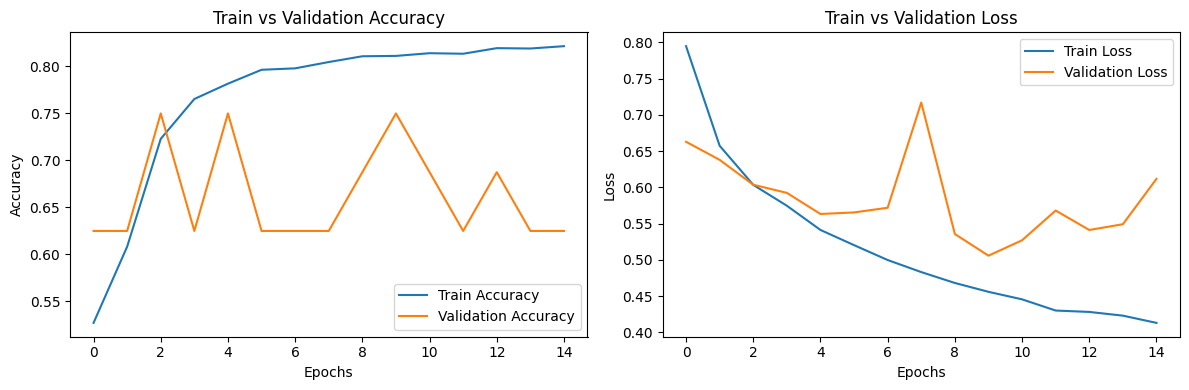

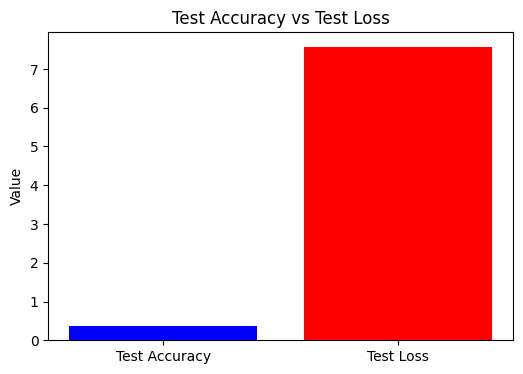

In [85]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_rs2.history['sparse_categorical_accuracy'], label='Train Accuracy')
plt.plot(history_rs2.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_rs2.history['loss'], label='Train Loss')
plt.plot(history_rs2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


La ResNet50 preentrenada logró un 82% de precisión en entrenamiento, 75% en validación y un rendimiento pobre en test con una pérdida elevada. Hay signos claros de sobreajuste.

## 7.6. Predicción con los datos de test

In [86]:
# Evaluación después de entrenar
y_true = []
y_pred = []

for x_batch, y_batch in test_dataset.unbatch():
    y_true.append(y_batch.numpy())
    pred = model_rs2.predict(tf.expand_dims(x_batch, 0))
    y_pred.append(np.argmax(pred))

print(classification_report(y_true, y_pred, target_names=class_names))
model_2_reporte=classification_report(y_true, y_pred, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

El modelo obtuvo un 38% de precisión en el test, con un promedio ponderado de F1-score de 20%. El modelo no generaliza bien y presenta un rendimiento deficiente en datos no vistos.

## 7.7 Matriz de confusión con los datos de test.

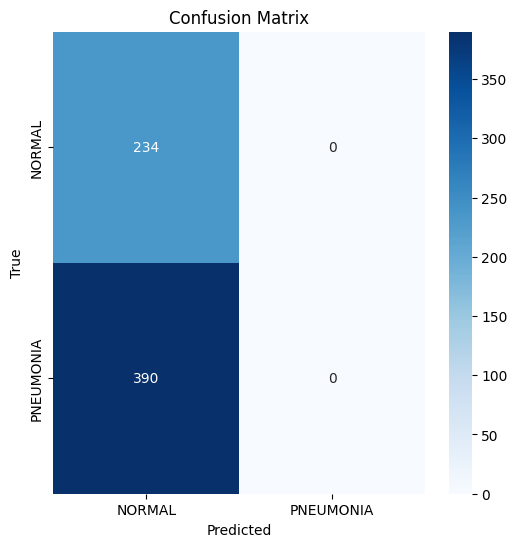

In [87]:
cm = confusion_matrix(y_true, y_pred)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


El modelo tiene un problema de sesgo severo hacia la clase NORMAL. No identifica casos de PNEUMONIA en el conjunto de prueba.

## 7.8. Predicción con los datos de validación.

In [88]:
# Evaluación después de entrenar
y_true_val = []
y_pred_val = []

for x_batch, y_batch in val_dataset.unbatch():
    y_true_val.append(y_batch.numpy())
    pred = model_rs2.predict(tf.expand_dims(x_batch, 0))
    y_pred_val.append(np.argmax(pred))

print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
              precision    recall  f1-score   support

      NORMAL       0.50      1.00      0.67         8
   PNEUMONIA       0.00      0.00      0.00         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Prog

* El modelo sólo predice NORMAL en validación.

* La precisión es del 50% porque la mitad de las imágenes realmente son normales.

* El modelo ignora completamente los casos de neumonía, lo cual es inaceptable en un sistema de diagnóstico.

## 7.9. Matriz de confusión con los datos de validación.

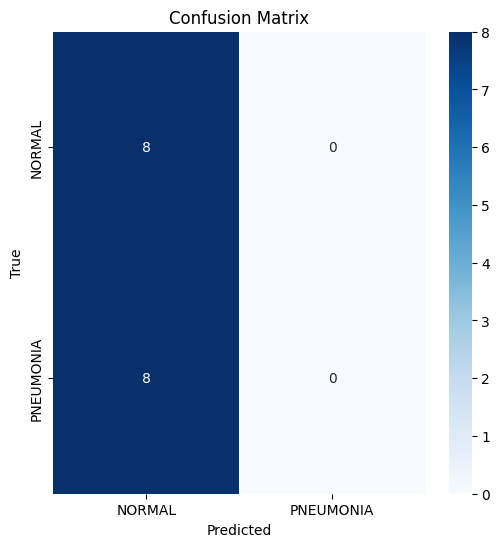

In [89]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

* El modelo clasifica todo como NORMAL, tanto en validación como en test.

* El recall para PNEUMONIA es 0%.

* Este modelo es inservible para diagnóstico clínico en este estado.

## 7.10. Curva ROC.
### 7.10.1. Curva ROC con los datos de test.

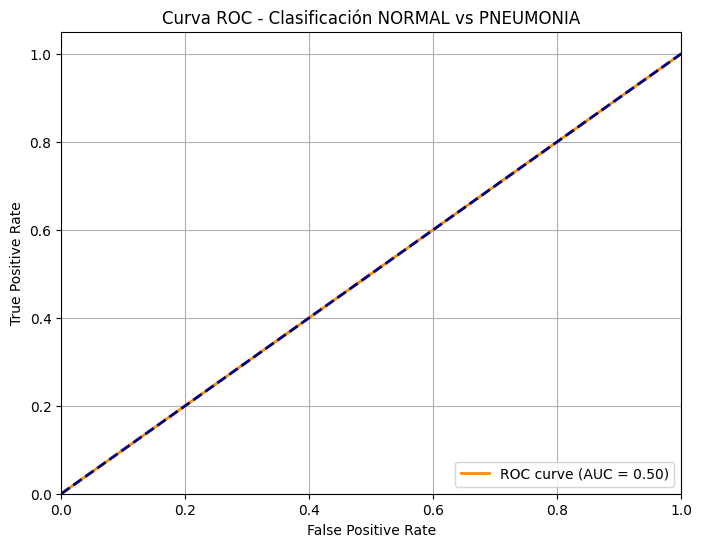

In [90]:
# Convertir a arrays
y_true_prob = np.array(y_true)
y_pred_prob = np.array(y_pred)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

*El área bajo la curva (AUC) es 0.50, lo cual indica que el modelo no tiene capacidad de discriminación; es decir, su desempeño es equivalente al de una clasificación aleatoria.
Esto sugiere que el modelo no ha aprendido a distinguir entre las clases y necesita mejoras, ya sea en los datos de entrenamiento, en la arquitectura del modelo, o en el proceso de ajuste de parámetros.

### 7.10.2. Curva ROC con los datos de validación.

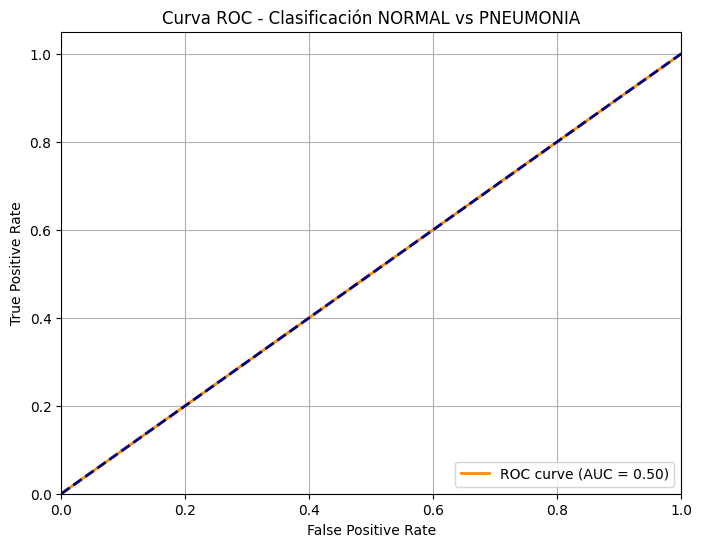

In [91]:
# Convertir a arrays
y_true_prob_val = np.array(y_true_val)
y_pred_prob_val = np.array(y_pred_val)

# Calcular curva ROC
fpr, tpr, _ = roc_curve(y_true_prob_val, y_pred_prob_val)
roc_auc = auc(fpr, tpr)

# Graficar curva ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Curva ROC - Clasificación NORMAL vs PNEUMONIA')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El área bajo la curva (AUC) es 0.50, lo que indica que el modelo no tiene capacidad para diferenciar entre las dos clases; su comportamiento es similar al de una decisión aleatoria.

## 7.11. Distribución de errores con los datos de test.

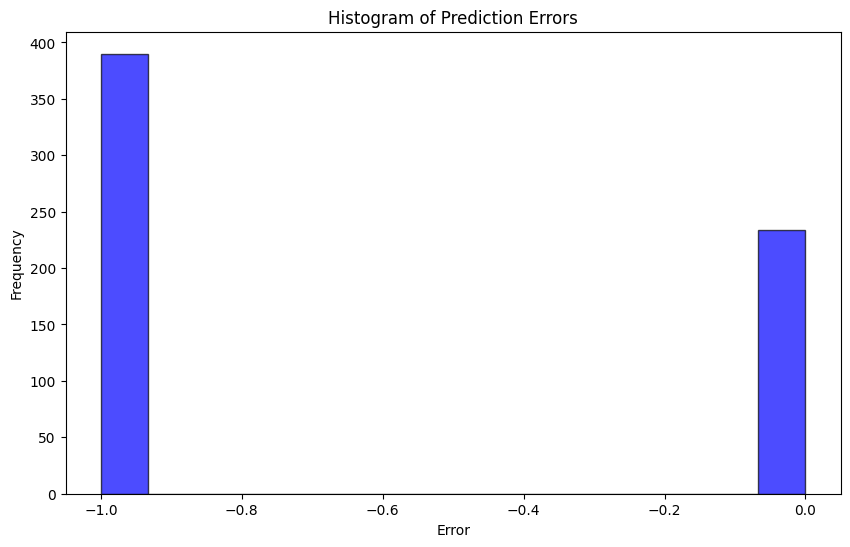

In [92]:
errors = np.array(y_pred) - np.array(y_true)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

 En este gráfico se observan dos barras muy marcadas:

Una barra en el valor -1, que indica un alto número de falsos negativos: el modelo predijo clase 0 (NORMAL), pero la clase real era 1 (PNEUMONIA).

Otra barra en el valor 0, que representa las predicciones correctas (sin error).

No hay barras en otros valores, lo que indica que el modelo hace solo dos tipos de salida: o acierta o falla completamente prediciendo la clase contraria.

Este comportamiento, junto con el AUC de 0.50, evidencia que el modelo no está aprendiendo correctamente. Está clasificando al azar o siempre predice una sola clase, lo cual debe corregirse ajustando el entrenamiento, revisando los datos, o probando otro modelo.

## 7.12. Distribución de errores con los datos de validación.

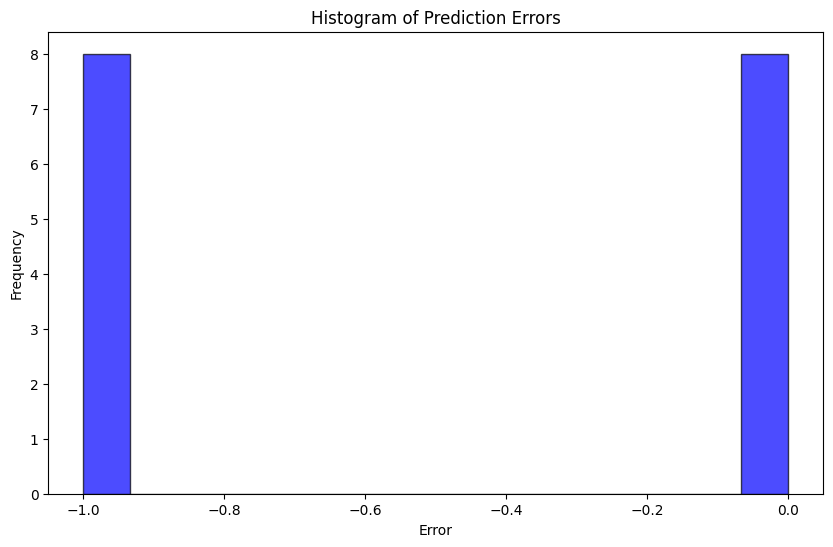

In [93]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

Este gráfico representa la distribución de los errores de predicción del modelo en el conjunto de validación. Los errores se calcularon restando el valor real (y_true_val) al valor predicho (y_pred_val), lo cual genera:

Un pico en 0: predicciones correctas.

Un pico en -1: casos donde el modelo predijo clase 0 (NORMAL), pero la clase real era 1 (PNEUMONIA), es decir, falsos negativos.

La gráfica muestra que el modelo acierta algunas veces, pero también falla con frecuencia al clasificar casos de neumonía como normales.

# 8. Modelo usando escala de grises y Data Aumentation

In [16]:
# Tamaño de las imágenes
img_height = 256
img_width = 256

# Augmentación (se mantiene exactamente como lo diste)
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255  # importante para normalizar pixel en [0,1]
)

# Cargar datos desde directorio, en escala de grises
train_dataset = datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary'  # o 'binary' si solo tienes 2 clases
)

# Usamos el mismo datagen solo para fit() y estadísticas internas
#datagen.fit(train_dataset)

# Validación y test no deben tener data augmentation
test_val_datagen = ImageDataGenerator(rescale=1./255)

val_dataset = test_val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

test_dataset = test_val_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.



1. Carga y preparación de datos

* Las imágenes se redimensionaron a 256x256 píxeles en escala de grises.

* Se normalizaron con rescale=1./255 para que los píxeles estén en el rango [0, 1].

2. Augmentación de datos (solo en entrenamiento):

* Rotación: hasta 30°

* Zoom: hasta 20%

* Desplazamientos horizontales/verticales: hasta 10%

* Volteo horizontal aleatorio

3. Distribución de datos:

* Entrenamiento: 5216 imágenes

* Validación: 16 imágenes

* Prueba (test): 624 imágenes

Nota: No se aplica augmentación en validación ni test.
class_mode='binary' porque hay solo dos clases: NORMAL y PNEUMONIA.

In [20]:
input_shape = (img_height, img_width, 1)  # 1 canal para escala de grises
inputs = tf.keras.Input(shape=input_shape)

# Convertir de 1 canal a 3 para compatibilidad con ResNet50
x = layers.Concatenate()([inputs, inputs, inputs])  # duplicamos canal 3 veces

In [21]:
# Carga de la ResNet50 preentrenada (sin la última capa)
base_model_rs3 = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3)
)
base_model_rs3.trainable = False

x = base_model_rs3(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation='sigmoid')(x)  # binario

model_rs3 = tf.keras.Model(inputs=inputs, outputs=outputs)


* Se utilizó ResNet50 preentrenada en ImageNet como base (include_top=False), sin su capa final.

* Entrada ajustada a imágenes de tamaño 256×256 con 3 canales (RGB).

* Las capas de ResNet50 se dejaron congeladas (trainable=False) para no modificar los pesos durante el entrenamiento.

Capas añadidas al modelo:

1. GlobalAveragePooling2D: reduce dimensionalidad.

2. Dense(256, relu): capa densa intermedia.

3. Dropout(0.5): regularización para evitar sobreajuste.

4. Dense(1, sigmoid): salida binaria (NORMAL vs PNEUMONIA).

## 8.2 resumen del modelo.

In [ ]:
odel_rs3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256, 256,  │          0 │ input_layer_3[0]… │
│ (Concatenate)       │ 3)                │            │ input_layer_3[0]… │
│                     │                   │            │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 8, 8,      │ 23,587,712 │ concatenate[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │    524,544 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │        257 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 24,112,513 (91.98 MB)

 Trainable params: 524,801 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 8.3 compilado y entrenamiento del modelo.

In [24]:
model_rs3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_rs3 = model_rs3.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=30,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5114 - loss: 0.7583

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.5115 - loss: 0.7581 - val_accuracy: 0.6875 - val_loss: 0.6618
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.5736 - loss: 0.6673 - val_accuracy: 0.6875 - val_loss: 0.6393
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.6857 - loss: 0.6225 - val_accuracy: 0.8125 - val_loss: 0.6188
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7328 - loss: 0.5999 - val_accuracy: 0.6250 - val_loss: 0.6039
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 302s 2s/step - accuracy: 0.7383 - loss: 0.5893 - val_accuracy: 0.5625 - val_loss: 0.6019
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 303s 2s/step - accuracy: 0.7794 - loss: 0.5501 - val_accuracy: 0.6875 - val_loss: 0.5755
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7855 - loss: 0.5338 - val_accuracy: 0.6875 - val_loss: 0.5629
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 293s 2s/step - accuracy: 0.7860 - loss: 0.5303 - val_accuracy: 0.687

In [25]:

test_loss, test_acc = model_rs3.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.8239 - loss: 0.4458
Test accuracy: 0.7147436141967773


Entrenamiento del modelo ResNet50 (transfer learning)

* Se usó el optimizador Adam con tasa de aprendizaje de 1e-4.

* Función de pérdida: binary_crossentropy (clasificación binaria).

* Métrica: accuracy.

* Se aplicó early stopping con patience=5 para evitar sobreentrenamiento.

* Se usó class_weight para compensar el desbalance de clases.

Resumen del entrenamiento:

* El modelo se entrenó hasta la época 19 (early stopping).

* La precisión en entrenamiento subió de 51% a 82%.

* La precisión en validación se mantuvo entre 56% y 81%.

* La pérdida en validación bajó de 0.66 a 0.51, lo que indica mejora gradual, pero con variaciones.

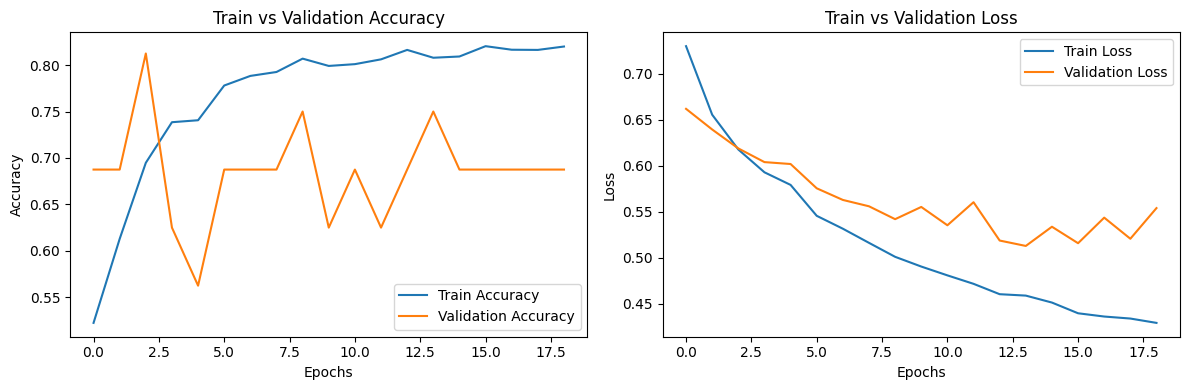

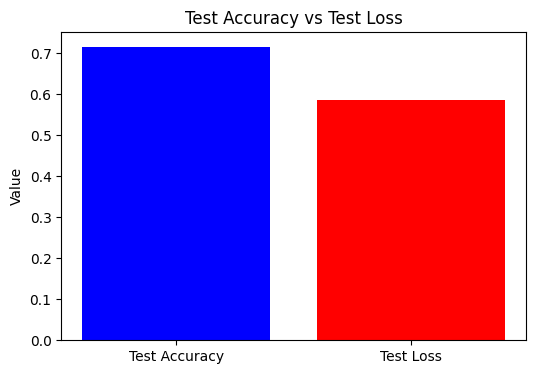

In [ ]:
-

Se entrenó el modelo con ResNet50 como base congelada, y las gráficas muestran el comportamiento por épocas:

* Precisión en entrenamiento (Train Accuracy) aumentó de forma constante hasta alcanzar más del 82%.

* Precisión en validación (Validation Accuracy) fue inestable por la poca cantidad de datos (16 imágenes), variando entre 56% y 81%.

* Pérdida de entrenamiento (Train Loss) bajó consistentemente.

* Pérdida de validación (Validation Loss) también disminuyó, aunque con oscilaciones.

Precisión en test: ~72%

Pérdida en test: ~0.59

# 9 Modelo

In [30]:
model_4 = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # Binaria
])



In [35]:
model_4.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,365,509 (5.21 MB)

 Trainable params: 454,849 (1.74 MB)

 Non-trainable params: 960 (3.75 KB)

 Optimizer params: 909,700 (3.47 MB)

In [31]:
# === 7. Compilación ===
model_4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [34]:
# === 8. Callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# === 9. Entrenamiento ===
history_4 = model_4.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.7940 - loss: 0.4076 - val_accuracy: 0.5000 - val_loss: 1.3948
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.8865 - loss: 0.2572 - val_accuracy: 0.5000 - val_loss: 2.7245
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 409s 3s/step - accuracy: 0.8973 - loss: 0.2440 - val_accuracy: 0.5000 - val_loss: 3.9737
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 407s 2s/step - accuracy: 0.9054 - loss: 0.2173 - val_accuracy: 0.5000 - val_loss: 1.7124
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 400s 2s/step - accuracy: 0.9078 - loss: 0.2148 - val_accuracy: 0.5000 - val_loss: 1.2079
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - accuracy: 0.9176 - loss: 0.1898 - val_accuracy: 0.5000 - val_loss: 2.8634
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 406s 2s/step - accuracy: 0.9188 - loss: 0.1854 - val_accuracy: 0.7500 - val_loss: 0.5515
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 401s 2s/step - accuracy: 0.9342 - loss: 0.1705 - val_accu

Modelo CNN personalizado (model_4)
* Arquitectura basada en 4 bloques Conv2D + MaxPooling + BatchNormalization.

* Usa GlobalAveragePooling2D, una capa densa y Dropout para reducir sobreajuste.

* Última capa: Dense(1, activation='sigmoid') para clasificación binaria (NORMAL vs PNEUMONIA).

Entrenamiento
* Optimizador: Adam con learning_rate=1e-4.

* Pérdida: binary_crossentropy.

* Se utilizó early stopping con paciencia de 5 épocas.

* Se aplicó class_weight para manejar desbalance de clases.

Resultados del entrenamiento
* La precisión en entrenamiento subió rápidamente, alcanzando hasta 94%.

* La precisión en validación fue muy inestable, oscilando entre 43% y 75%.

In [36]:

test_loss, test_acc = model_4.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 395ms/step - accuracy: 0.8398 - loss: 0.3735
Test accuracy: 0.870192289352417


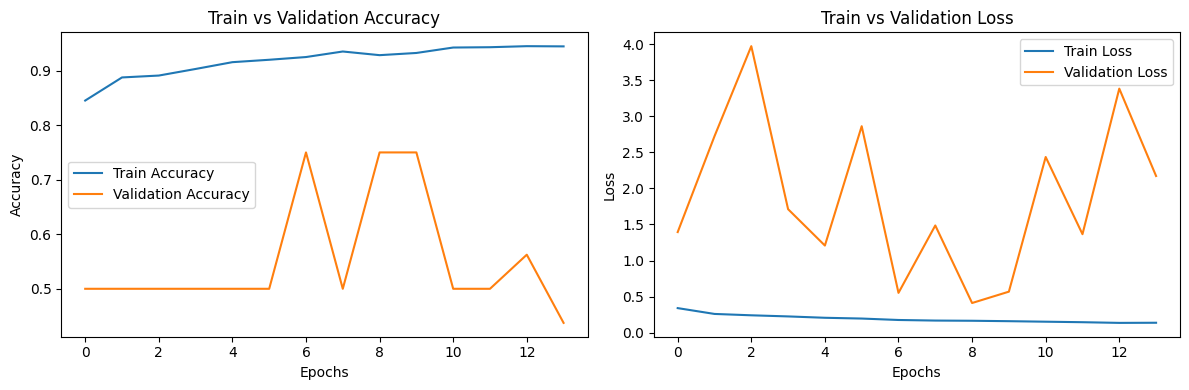

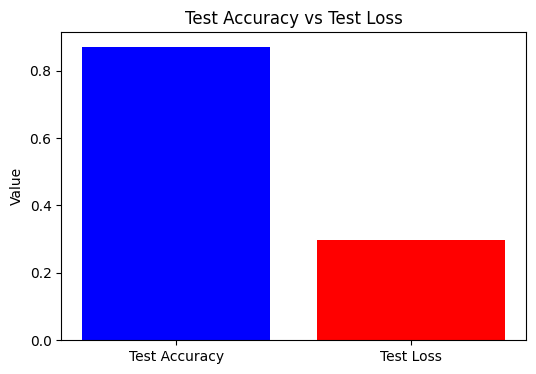

In [37]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_4.history['loss'], label='Train Loss')
plt.plot(history_4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


1. Modelo con ResNet50 (modelo_rs3):
* Entrenamiento:
  * Precisión llegó al 82%.
  * Pérdida bajó de 0.75 a 0.43.
* Validación:
  * Precisión inestable (fluctuando entre 56% y 81%).
  * Pérdida no disminuyó de forma clara: se mantuvo entre 0.55 y 0.66, con altibajos.

2. Modelo CNN personalizado (model_4):
* Entrenamiento:
  * Precisión subió rápidamente hasta 94%.
  * Pérdida bajó de 0.4 a 0.13, lo cual es muy bueno.
* Validación:
  * Precisión inestable, pero en algunos momentos llegó a 75%.
  * Pérdida altamente variable, con picos hasta 3.9 (indica overfitting fuerte).

3. Desempeño en el conjunto de prueba
* ResNet50 (modelo_rs3):
  * Test Accuracy: ~72%
  * Test Loss: ~0.58
* Resultado aceptable, pero no sobresaliente.
*  CNN personalizada (model_4):
  * Test Accuracy: ~87%
  * Test Loss: ~0.29
* Mejor desempeño en test. Aunque hubo overfitting en validación, generalizó bien en el test.



## 9.2. redicción con los datos de validación.

In [41]:
y_true_val = []
y_pred_val = []

for step in range(len(test_dataset)):
    x_batch, y_batch = test_dataset[step]
    y_true_val.extend(y_batch)
    preds = model_4.predict(x_batch)
    y_pred_val.extend((preds > 0.5).astype(int).flatten())


print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 416ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
              precision    recall  f1-score   support

      NORMAL       0.87      0.77      0.82       234
   PNEUMONIA       0.87      0.93      0.90       390

    accuracy                           0.87       624
  

## 9.3. Matriz de confusión con los datos de validación.

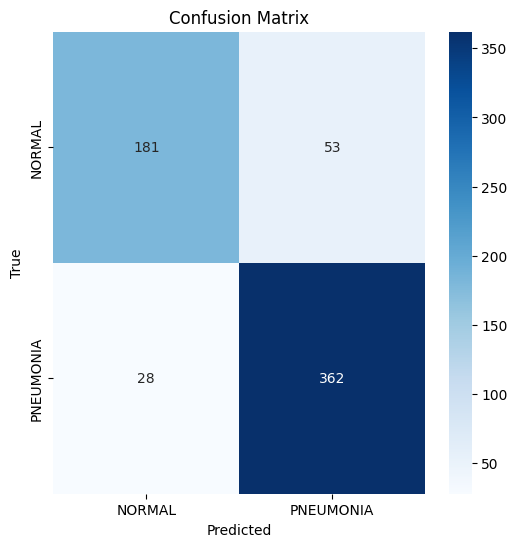

In [42]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

El modelo es muy bueno detectando neumonía (recall de 92.8%).

Tiene más dificultades detectando casos normales (recall 77.4%), lo que sugiere falsos positivos de neumonía.

## 9.4. Curva ROC.
### 9.4.1. Curva ROC con los datos de test.

In [49]:
print("Ejemplos en y_true:", len(y_true_val))
print("Ejemplos en y_pred_prob:", len(y_pred_prob))
print("Valores únicos en y_true:", set(y_true_val))


Ejemplos en y_true: 624
Ejemplos en y_pred_prob: 624
Valores únicos en y_true: {0.0, 1.0}


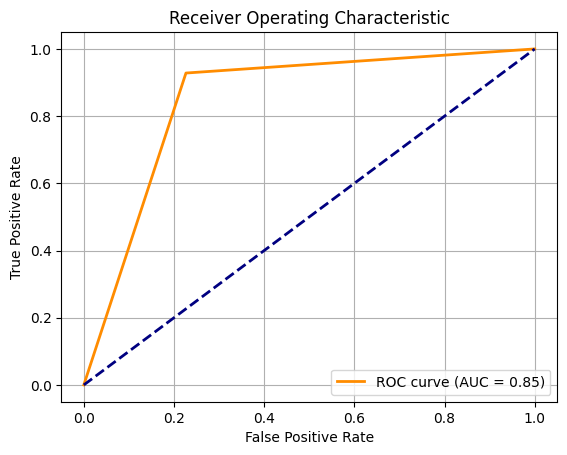

In [50]:
# Convertir a arrays

fpr, tpr, _ = roc_curve(y_true_val, y_pred_prob)  # usa las probabilidades, no etiquetas
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

AUC = 0.85 → Significa que hay un 85 % de probabilidad de que el modelo asigne un mayor puntaje a una radiografía con neumonía que a una sin neumonía.

La curva se aleja bastante de la diagonal (que representa un modelo aleatorio), lo cual es deseable.

La True Positive Rate (TPR) es muy alta para bajos valores de False Positive Rate (FPR) → ideal para contextos médicos donde es más crítico no perder casos positivos.

## 9.5. Distribución de errores con los datos de test.

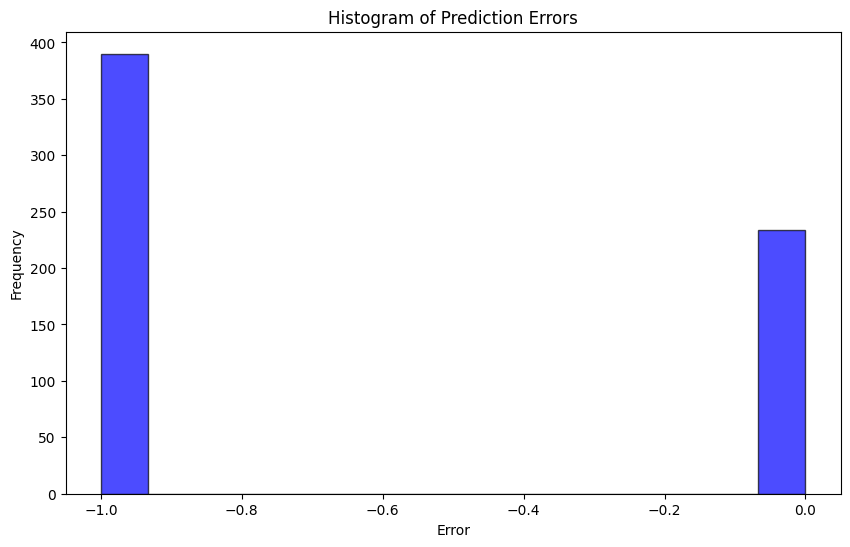

In [ ]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

Este histograma muestra dos picos claros:

Error = 0 → predicciones correctas.

Error = -1 → errores donde el modelo predijo PNEUMONIA (1) cuando la etiqueta real era NORMAL (0) (falsos positivos).

No se observa error = +1, es decir, el modelo casi no cometió falsos negativos (no predijo “NORMAL” cuando era “PNEUMONIA”).


In [43]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# Útil si ya tienes la arquitectura definida por código
model_4.save_weights('pesos_CNN.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_4, "modelo_CNNF")




INFO:tensorflow:Assets written to: modelo_CNNF\assets


INFO:tensorflow:Assets written to: modelo_CNNF\assets


In [44]:
from keras.layers import TFSMLayer

# Cargar como capa para predicción
modelo_inferencia = TFSMLayer("modelo_CNNF", call_endpoint="serving_default")


In [52]:
model_5 = models.Sequential()
model_5.add(layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = input_shape))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.Dropout(0.1))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.BatchNormalization())
model_5.add(layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model_5.add(layers.Flatten())
model_5.add(layers.Dense(units = 128 , activation = 'relu'))
model_5.add(layers.Dropout(0.2))
model_5.add(layers.Dense(units = 1 , activation = 'sigmoid'))

c:\ProgramData\anaconda3\envs\mlops\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [53]:
model_5.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 2,524,353 (9.63 MB)

 Trainable params: 2,523,265 (9.63 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [54]:
# === 7. Compilación ===
model_5.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy']
)



In [55]:
# === 8. Callbacks ===
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# === 9. Entrenamiento ===
history_5 = model_5.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stop],
    class_weight=class_weights
)

Epoch 1/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.8099 - loss: 0.5026 - val_accuracy: 0.5000 - val_loss: 5.9615
Epoch 2/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 359s 2s/step - accuracy: 0.9075 - loss: 0.2206 - val_accuracy: 0.5000 - val_loss: 8.3840
Epoch 3/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.9162 - loss: 0.2034 - val_accuracy: 0.5000 - val_loss: 6.8587
Epoch 4/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 362s 2s/step - accuracy: 0.9288 - loss: 0.1790 - val_accuracy: 0.5000 - val_loss: 5.3622
Epoch 5/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.9280 - loss: 0.1762 - val_accuracy: 0.5000 - val_loss: 3.0948
Epoch 6/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 405s 2s/step - accuracy: 0.9435 - loss: 0.1451 - val_accuracy: 0.6250 - val_loss: 0.8027
Epoch 7/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 342s 2s/step - accuracy: 0.9456 - loss: 0.1497 - val_accuracy: 0.6875 - val_loss: 0.5633
Epoch 8/30
163/163 ━━━━━━━━━━━━━━━━━━━━ 333s 2s/step - accuracy: 0.9444 - loss: 0.1482 - val_accu

In [56]:

test_loss, test_acc = model_5.evaluate(test_dataset)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 582ms/step - accuracy: 0.8977 - loss: 0.2907
Test accuracy: 0.9006410241127014


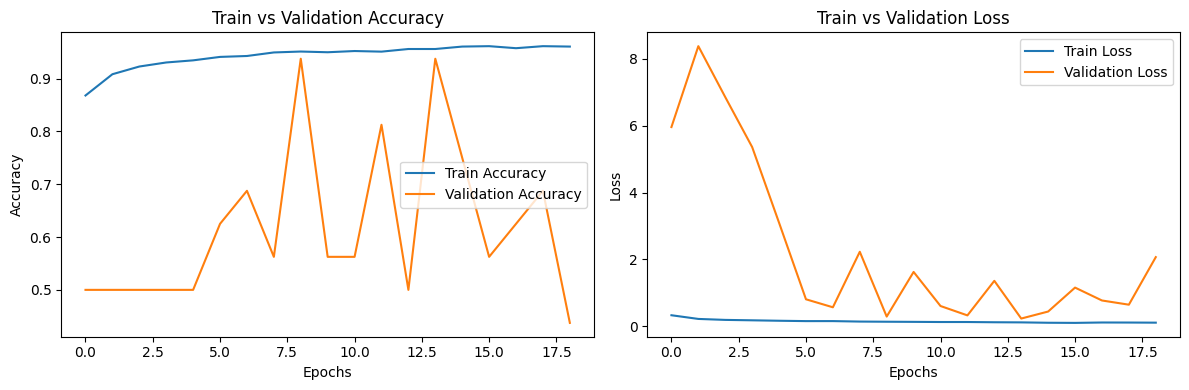

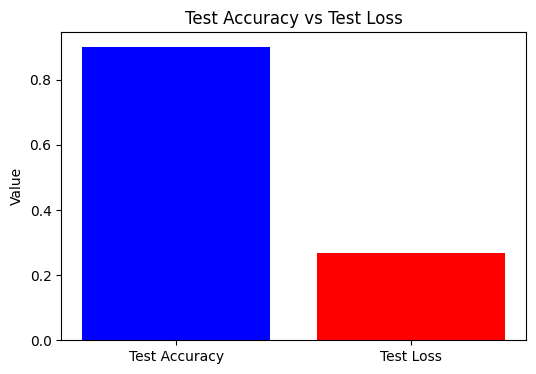

In [57]:

# Precisión
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train vs Validation Accuracy')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history_5.history['loss'], label='Train Loss')
plt.plot(history_5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Graficar precisión del test vs pérdida del test
# Notar que esto no es por época sino un solo punto después de evaluar el conjunto de prueba
plt.figure(figsize=(6, 4))
plt.bar(['Test Accuracy', 'Test Loss'], [test_acc, test_loss], color=['blue', 'red'])
plt.ylabel('Value')
plt.title('Test Accuracy vs Test Loss')
plt.show()
     


 Modelo 5 es el más preciso, con una accuracy del 89% en test y baja pérdida. Sin embargo, el gráfico de validación muestra alto sobreajuste: la pérdida de validación es mucho más alta que la de entrenamiento.
  Modelo 4 es una buena alternativa, con 86% de accuracy y un ROC AUC de 0.85, lo que indica buen equilibrio entre sensibilidad y especificidad.

## 9.6. Predicción con los datos de validación.

In [58]:
y_true_val = []
y_pred_val = []

for step in range(len(test_dataset)):
    x_batch, y_batch = test_dataset[step]
    y_true_val.extend(y_batch)
    preds = model_5.predict(x_batch)
    y_pred_val.extend((preds > 0.5).astype(int).flatten())


print(classification_report(y_true_val, y_pred_val, target_names=class_names))
model_2_reporte=classification_report(y_true_val, y_pred_val, target_names=class_names,output_dict=True)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 650ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step
              precision    recall  f1-score   support

      NORMAL       0.86      0.87      0.87       234
   PNEUMONIA       0.92      0.92      0.92       390

    accuracy                           0.90       624
  

 El modelo 5 es el mejor en términos de desempeño general, logrando una precisión del 90%, y excelentes métricas de precisión, recall y F1-score para ambas clases.

## 9.8  Matriz de confusión con los datos de validación.

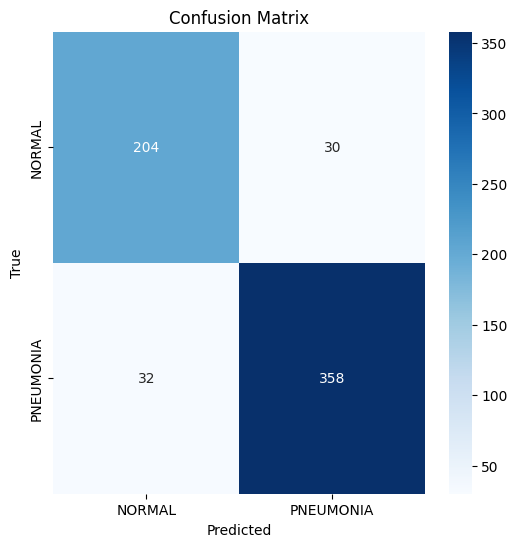

In [59]:
cm = confusion_matrix(y_true_val, y_pred_val)
labels_names = ['NORMAL', 'PNEUMONIA']

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels_names, yticklabels=labels_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Para clase NORMAL:
* Precision (NORMAL) = 204 / (204 + 32) = 0.864
* Recall (NORMAL) = 204 / (204 + 30) = 0.871
* F1-score (NORMAL) ≈ 0.867

Para clase PNEUMONIA:
* Precision (PNEUMONIA) = 358 / (358 + 30) = 0.923
* Recall (PNEUMONIA) = 358 / (358 + 32) = 0.918
* F1-score (PNEUMONIA) ≈ 0.921

Global:
* Accuracy total = (204 + 358) / 624 = 0.90 

## 9.10. Curva ROC.
### 9.10.1. Curva ROC con los datos de test.

In [60]:
print("Ejemplos en y_true:", len(y_true_val))
print("Ejemplos en y_pred_prob:", len(y_pred_prob))
print("Valores únicos en y_true:", set(y_true_val))


Ejemplos en y_true: 624
Ejemplos en y_pred_prob: 624
Valores únicos en y_true: {0.0, 1.0}


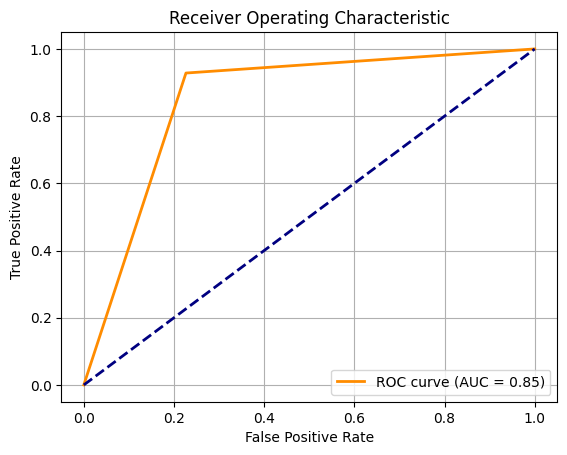

In [61]:
# Convertir a arrays

fpr, tpr, _ = roc_curve(y_true_val, y_pred_prob)  # usa las probabilidades, no etiquetas
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

El modelo 5 (CNN profundo con Batch Normalization y Dropout) es el que ofrece mejor desempeño general, alcanzando un 90% de accuracy, un AUC de 0.85 y una matriz de confusión bastante equilibrada.

## 9.11 Distribución de errores con los datos de test.

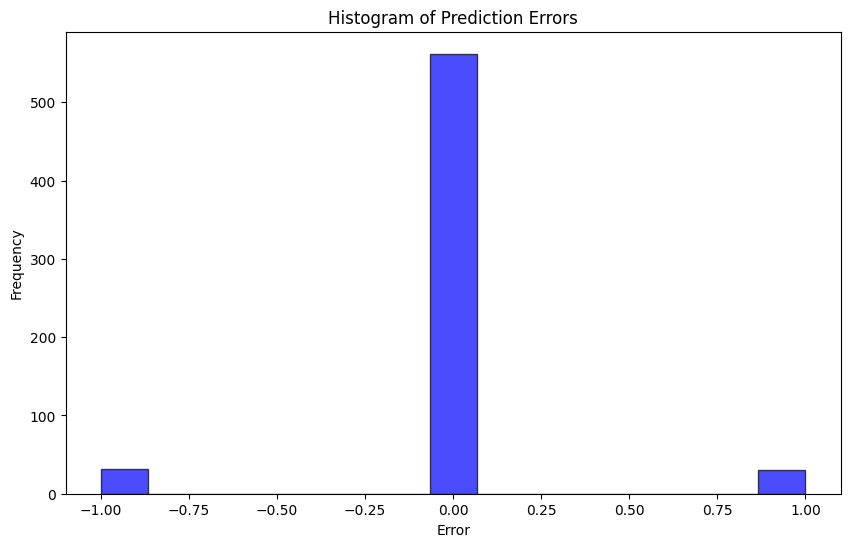

In [ ]:
errors = np.array(y_pred_val) - np.array(y_true_val)

# Graficar el histograma de la distribución de errores
plt.figure(figsize=(10, 6))
#plt.hist(errors, bins=np.arange(errors.min(), errors.max()+1), alpha=0.7, color='blue', edgecolor='black')
plt.hist(errors, bins=15, alpha=0.7, color='blue', edgecolor='black')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Histogram of Prediction Errors')
plt.show()

La gran mayoría de los errores están en el cero, lo que confirma el alto rendimiento general del modelo (coherente con el 90 % de accuracy).

In [63]:
# Guarda el modelo completo (arquitectura + pesos + optimizer)
#model_3.save('modelo_VGGNet16.h5')
# Guarda el modelo como carpeta con archivos de metadatos
#model_3.save('modelo_VGGNet16F.h5')  # crea una carpeta
# Útil si ya tienes la arquitectura definida por código
model_5.save_weights('pesos_CNN2.weights.h5')
# Guarda como SavedModel (crea una carpeta con todos los archivos)
tf.saved_model.save(model_5, "modelo_CNN2F")




INFO:tensorflow:Assets written to: modelo_CNN2F\assets


INFO:tensorflow:Assets written to: modelo_CNN2F\assets


In [64]:
from keras.layers import TFSMLayer

# Cargar como capa para predicción
modelo_inferencia = TFSMLayer("modelo_CNN2F", call_endpoint="serving_default")
